## Продуктовая аналитика в Яндекс.Афише
*По условиям проекта данные предоставлены в рамках стажировки в Яндекс.Афише. Нужно помочь макретологам оптимизировать маркетинговые затраты.
Данныe от ЯндексАфиши с июня 2017 по конец мая 2018 года включают в себя:*
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов


*Нам надо изучить:* 
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается

<p>&nbsp;</p>

**Перед тем как перейти к коду, надо сказать, что данные были предоставлены мне в рамках прохождения курса по продуктовой аналитике в Яндекс Практикуме - датасеты являются собственностью Яндекса, поэтому я не могу их выложить. Весь код написан мной.**

## Шаг 1.
- загрузим нужные библиотеки
- посмотрим на данные 
- переименуем столбцы
- приведем данные к нужным типам 
- посмотрим на количество пропусков и дубликатов


*Стоит заранее сделать оговорку, что валюта, в которой сделаны все рассчеты, рубли.* 

In [1]:
import datetime as dt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.float.format', lambda x: '%.3f' %x)
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML('<style>.container{width:75%! important;}</style>'))
from IPython.display import display, Markdown

In [2]:
# загрузим датасеты 
df_costs = pd.read_csv('costs.csv')
df_orders = pd.read_csv('orders_log.csv')
df_visits = pd.read_csv('visits_log.csv')

# выведем общую информацию о них
def print_info(df):
    df.info()
    display(df.describe())
    display(df)

for df in [df_costs, df_orders, df_visits]:
    print_info(df)
    print('')
    print('-----------------------------------------------------------')
    print('')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,costs
count,2542.000,2542.000
mean,4.857,129.477
std,3.182,156.297
min,1.000,0.540
25%,2.000,21.945
50%,4.000,77.295
75%,9.000,170.065
max,10.000,1788.280


,source_id,dt,costs
0,1,2017-06-01,75.200
1,1,2017-06-02,62.250
2,1,2017-06-03,36.530
3,1,2017-06-04,55.000
4,1,2017-06-05,57.080
...,...,...,...
2537,10,2018-05-27,9.920
2538,10,2018-05-28,21.260
2539,10,2018-05-29,11.320
2540,10,2018-05-30,33.150



-----------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Revenue,Uid
count,50415.000,50415.000
mean,5.000,9098160634289729536.000
std,21.818,5285741550834715648.000
min,0.000,313578113262317.000
25%,1.220,4533566627250599936.000
50%,2.500,9102273602618561536.000
75%,4.890,13682901980465401856.000
max,2633.280,18446167067214817280.000


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.000,10329302124590727494
1,2017-06-01 00:25:00,0.550,11627257723692907447
2,2017-06-01 00:27:00,0.370,17903680561304213844
3,2017-06-01 00:29:00,0.550,16109239769442553005
4,2017-06-01 07:58:00,0.370,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.640,12296626599487328624
50411,2018-05-31 23:50:00,5.800,11369640365507475976
50412,2018-05-31 23:54:00,0.300,1786462140797698849
50413,2018-05-31 23:56:00,3.670,3993697860786194247



-----------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Source Id,Uid
count,359400.000,359400.000
mean,3.751,9202556994354921472.000
std,1.917,5298432824659611648.000
min,1.000,11863502262781.000
25%,3.000,4613406732167550976.000
50%,4.000,9227412908740601856.000
75%,5.000,13728237011236173824.000
max,10.000,18446676030785673216.000


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485



-----------------------------------------------------------



### Описание данных
<p>&nbsp;</p>

*Таблица **df_visits** (лог сервера с информацией о посещениях сайта):*
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

<p>&nbsp;</p>

*Таблица **df_orders** (информация о заказах):*
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

<p>&nbsp;</p>

*Таблица **df_costs** (информация о затратах на маркетинг):*
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

In [3]:
# посмотрим на название колонок 
for df in [df_costs, df_orders, df_visits]:
    print(df.columns.to_list())

['source_id', 'dt', 'costs']
['Buy Ts', 'Revenue', 'Uid']
['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid']


### На данном этапе в данных есть следующие проблемы: 
1. неудачные названия столбцов 
2. отсутствие нижнего дефиса в названиях столбцов
3. большие буквы в названиях столбцов
4. неверный тип данных в столбцах с датами 

In [4]:
# приведем названия столбцов к нижнему регистру
for df in [df_costs, df_orders, df_visits]:
    df.columns = map(str.lower, df.columns)
    
# переименуем столбцы    
df_costs = df_costs.rename({'dt':'dt_of_commercial', 'costs':'cost_for_marketing_source'}, axis='columns')
df_orders = df_orders.rename({'buy ts':'dt_of_order'}, axis='columns')
df_visits = df_visits.rename({'device':'device_cat', 'start ts':'dt_start_of_session',
                              'end ts':'dt_end_of_session', 'source id': 'commercial_source_id'}, 
                             axis = 'columns')

# проверим результаты
for df in [df_costs, df_orders, df_visits]:
    display(df.columns.to_list())

['source_id', 'dt_of_commercial', 'cost_for_marketing_source']

['dt_of_order', 'revenue', 'uid']

['device_cat',
 'dt_end_of_session',
 'commercial_source_id',
 'dt_start_of_session',
 'uid']

In [5]:
# напишем функцию для преобразования к дате и извлечения из нее дня, недели, месяца и года
def make_date_and_add_columns(df, column_name, 
                              date_column_name, week_column_name, 
                              month_column_name, year_column_name):
    '''
        Напишем функцию, которая будет добавлять колонки с нужными датами
    '''
    df = df.copy()
    df[column_name] = pd.to_datetime(df[column_name])
    df[date_column_name] = df[column_name].astype('datetime64[D]')
    df[week_column_name] = df[column_name].astype('datetime64[W]')
    df[month_column_name] = df[column_name].astype('datetime64[M]')
    df[year_column_name] = df[column_name].astype('datetime64[Y]')
    return df

# применим ее для df_visits и по мере необходимости будем применять ее к остальным 
# датафреймам 
df_costs = df_costs.pipe(make_date_and_add_columns, 'dt_of_commercial', 
                         'day_of_commercial','week_of_commercial', 
                         'month_of_commercial', 'year_of_commercial')

# в остальных датафремах поменяем тип столбцов с датой вручную 
# (мы пока не можем быть уверенными, что для исследования нам понадобятся 
# день,неделя, месяц и год в остальных фреймах)
def transform_into_date_type(df, columns):
    """Напишем функцию, которая будет брать датафрейм и колонку
    и менять тип этой колонки на datetime64"""
    df = df.copy()
    for col in columns: 
        df[col] = pd.to_datetime(df[col])
    return df

df_costs = transform_into_date_type(df_costs, ['dt_of_commercial'])
df_orders = transform_into_date_type(df_orders, ['dt_of_order'])
df_visits = transform_into_date_type(df_visits, ['dt_end_of_session'])

In [6]:
# посмотрим на количество дубликатов и пропусков в датафреймах
names = {'df_visits': df_visits, 'df_costs': df_costs, 'df_orders': df_orders}
for name, df in names.items():
    print('Дубликатов в датафрейме', name, df.duplicated().sum())
    for column in df.columns: 
        print('Пропусков в столбце', column, ':', df[column].isna().sum())

Дубликатов в датафрейме df_visits 0
Пропусков в столбце device_cat : 0
Пропусков в столбце dt_end_of_session : 0
Пропусков в столбце commercial_source_id : 0
Пропусков в столбце dt_start_of_session : 0
Пропусков в столбце uid : 0
Дубликатов в датафрейме df_costs 0
Пропусков в столбце source_id : 0
Пропусков в столбце dt_of_commercial : 0
Пропусков в столбце cost_for_marketing_source : 0
Пропусков в столбце day_of_commercial : 0
Пропусков в столбце week_of_commercial : 0
Пропусков в столбце month_of_commercial : 0
Пропусков в столбце year_of_commercial : 0
Дубликатов в датафрейме df_orders 0
Пропусков в столбце dt_of_order : 0
Пропусков в столбце revenue : 0
Пропусков в столбце uid : 0


**Отлично. Данные без пропусков и дубликатов, а соответственно готовы для исследования.**

In [7]:
# перед тем как перейти дальше еще раз проверим, все ли у нас отработало
for df in [df_costs, df_orders, df_visits]:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   source_id                  2542 non-null   int64         
 1   dt_of_commercial           2542 non-null   datetime64[ns]
 2   cost_for_marketing_source  2542 non-null   float64       
 3   day_of_commercial          2542 non-null   datetime64[ns]
 4   week_of_commercial         2542 non-null   datetime64[ns]
 5   month_of_commercial        2542 non-null   datetime64[ns]
 6   year_of_commercial         2542 non-null   datetime64[ns]
dtypes: datetime64[ns](5), float64(1), int64(1)
memory usage: 139.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   dt_of_order  50415 non-null  datetime64[

**Все отработало. Переходим ко второму шагу.** 

## Шаг 2. 

Посчитаем продуктовые метрики и ответим на вопросы: 
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

<p>&nbsp;</p>

*Перед тем как ответить на эти вопросы, стоит внести небольшое пояснение: в наших датасетах присутствуют, во-первых, разные типы устройств, а во-вторых, разные типы маргетинговых источников. Поэтому большинство метрик будут посчитаны или для определенного устройства, или для маркетингового источника, или для обоих.*


-----------------------------------------------------------------------------------------------------------
Процент людей, использующих мобильную и десктопную версии:


desktop   0.731
touch     0.269
Name: device_cat, dtype: float64


-----------------------------------------------------------------------------------------------------------
В датафреме представлено 228169 уникальных пользователей

-----------------------------------------------------------------------------------------------------------
Самая ранняя сессия представленная в датафрейме: 2017-06-01 00:01:00 , а самая поздняя 2018-05-31 23:59:00

-----------------------------------------------------------------------------------------------------------
В датафрейме приcутствуют 9 маркетинговых каналов, из которых 7 платных


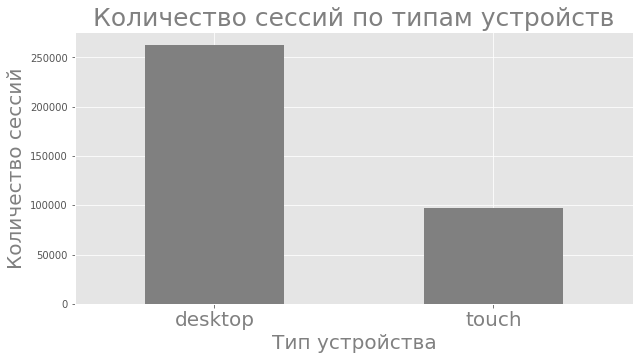

In [8]:
# Шаг 2 - посчитаем engagement metrics и построим к ним графики
# зададим стиль для будущих графиков
plt.style.use('ggplot')

# посмотрим на доли сессий по категориям устройств 
df_visits['device_cat'].value_counts().plot(
                                            kind='bar', figsize=(10,5), 
                                            grid=True, color='grey'
)
plt.title('Количество сессий по типам устройств', fontsize=25, color='grey')
plt.xlabel('Тип устройства', fontsize=20, color='grey')
plt.ylabel('Количество сессий', fontsize=20, color='grey')
plt.xticks(rotation=0, fontsize=20, color='grey')

print('------------------------------------------\
-----------------------------------------------------------------')
print('\033[1m' + 'Процент людей, использующих мобильную и десктопную версии:' + '\033[0m' )
display(df_visits['device_cat'].value_counts(normalize = True))
print('')
print('------------------------------------------\
-----------------------------------------------------------------')
print('\033[1m' + 'В датафреме представлено', df_visits['uid'].nunique(), 
      'уникальных пользователей' + '\033[0m' )

print('')
print('------------------------------------------\
-----------------------------------------------------------------')
print('\033[1m' + 'Самая ранняя сессия представленная в датафрейме:' + 
      '\033[0m' , df_visits['dt_start_of_session'].\
      min(),',','\033[1m' + 'а самая поздняя' + '\033[0m' , 
      df_visits['dt_start_of_session'].max())

print('')
print('------------------------------------------\
-----------------------------------------------------------------')
df_visits['commercial_source_id'].value_counts()
print('\033[1m' + 'В датафрейме приcутствуют', df_visits['commercial_source_id'].\
      nunique(),
      'маркетинговых каналов, из которых', df_costs['source_id'].nunique(), 
      'платных' + '\033[0m' )

*Видим, что **десктопная версия популярнее мобильной**, на нее приходится около **73%** визитов, в то время как на мобильную лишь **27%.** Возникает довольно логичный вопрос: а стоит ли нам делать третью категорию пользователей, которые заходят на сайт с обоих устройств? Для ответа на этот вопрос посмотрим на долю таких пользователей.*

In [9]:
# сделаем два множества и проверим их пересечение 
touch_users = df_visits.query('device_cat == "touch"')
desktop_users = df_visits.query('device_cat == "desktop"')
touch_set = set(touch_users['uid'])
desktop_set = set(desktop_users['uid'])

result = []
for uid in touch_set: 
    if uid in desktop_set: 
        result.append(uid) 
        
percent_of_users_who_use_both_platforms = len(result) / len(df_visits) 
print('\033[1m' + 'Процент пользователей, которые используют одновременно обе \
платформы составляет {:.1%}'.\
      format(percent_of_users_who_use_both_platforms))

Процент пользователей, которые используют одновременно обе платформы составляет 2.1%


Лишь **2%** пользователей используют обе платформы, поэтому можно сохранить разделение пользователей лишь на тех, кто заходит только с десктопа и на тех, кто заходит только с мобильной версии. 

# Сколько людей пользуются в день, неделю, месяц?

In [10]:
# приведем данные с визитами к типу datetime64
df_visits = df_visits.pipe(
                           make_date_and_add_columns, 'dt_start_of_session', 
                           'dt_start_of_session_day','dt_start_of_session_week', 
                           'dt_start_of_session_month', 'dt_start_of_session_year'
)

# посчитаем User Engagement Metrics
dau_total = df_visits.groupby('dt_start_of_session_day').\
agg({'uid':'nunique'}).mean().astype(int)
wau_total = df_visits.groupby(['dt_start_of_session_year', 
                               'dt_start_of_session_week']).\
agg({'uid':'nunique'}).mean().astype(int)
mau_total = df_visits.groupby(['dt_start_of_session_year', 
                               'dt_start_of_session_month']).\
agg({'uid':'nunique'}).mean().astype(int)

# для удобного формата вывода данных сделаем словарик и выведем метрику и количество 
# пользователей в цикле
sticky_metrics = {'Дневная аудитория': dau_total, 'Недельная аудитория':wau_total, 
                  'Месячная аудитория':mau_total}
for name,metric in sticky_metrics.items():
    print('\033[1m' + name + '\033[0m',':', int(metric), 'уникальных пользователей.')

# посмотрим 'липкость' продукта
sticky_wau = dau_total / wau_total * 100
sticky_mau = wau_total/mau_total * 100
print('\033[1m' + 'Отношение среднестатистического числа уникальных пользователей в \
день к числу уникальных пользователей в неделю:', 
      int(sticky_wau), '%'+ '\033[0m')
print('\033[1m' + 'Отношение среднестатистического числа уникальных \
пользователей в неделю к числу уникальных пользователей в месяц:', 
      int(sticky_mau), '%' + '\033[0m')

Дневная аудитория : 907 уникальных пользователей.
Недельная аудитория : 5621 уникальных пользователей.
Месячная аудитория : 23228 уникальных пользователей.
Отношение среднестатистического числа уникальных пользователей в день к числу уникальных пользователей в неделю: 16 %
Отношение среднестатистического числа уникальных пользователей в неделю к числу уникальных пользователей в месяц: 24 %


Получили "липкость" нашего продукта. По данным процентам можно сделать вывод, что **у Яндекс афиши есть небольшая пользовательская база, но большая часть пользователей не задерживается в приложении**. Теперь посмотрим на динамику изменения данных метрик.   

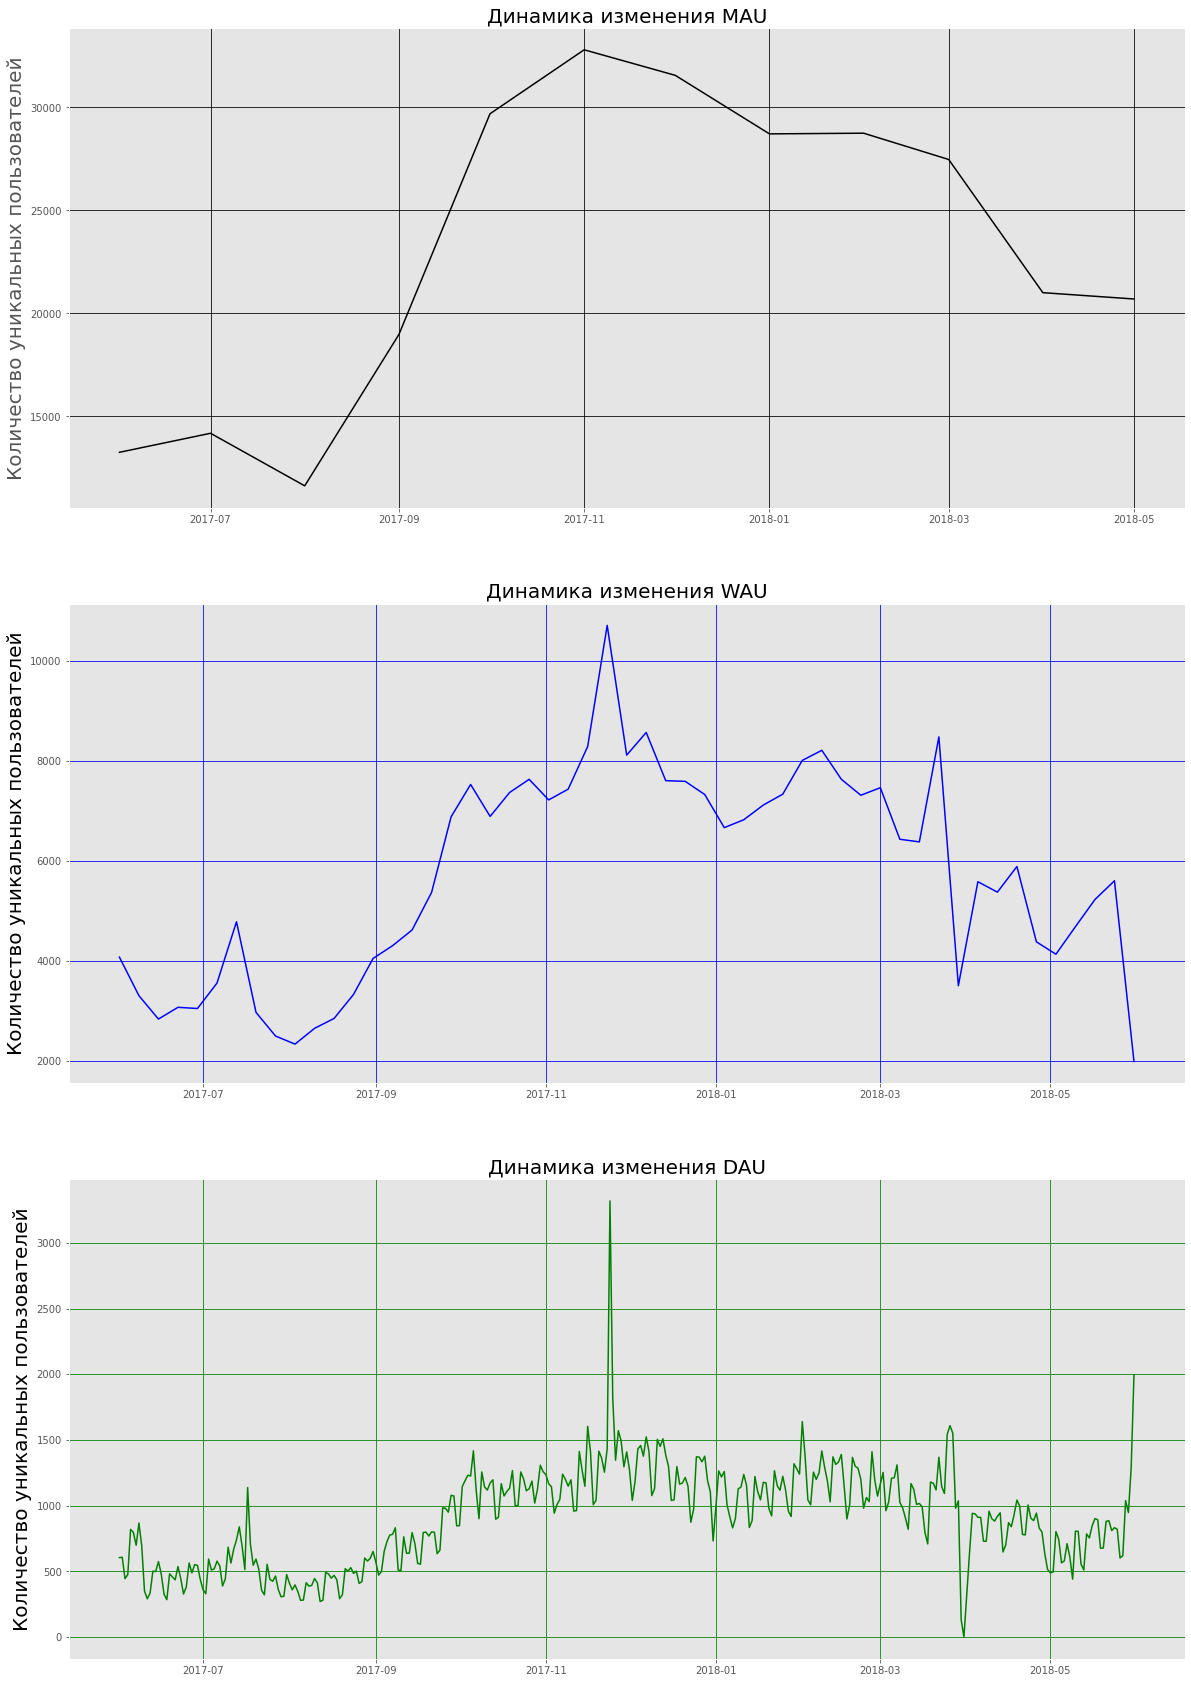

In [11]:
# построим графики изменения DAU, WAU, MAU
fig,ax = plt.subplots(3,1, figsize=(20, 30))
ax[0].plot(df_visits.groupby('dt_start_of_session_month').\
           agg({'uid':'nunique'}), color='black')
# первый сабплот для месяца
ax[0].set_ylabel('Количество уникальных пользователей', fontsize=20)
ax[0].set_title('Динамика изменения MAU', fontsize=20, color='black')
ax[0].grid(color='black')

# второй для недели
ax[1].plot(df_visits.groupby('dt_start_of_session_week').\
           agg({'uid':'nunique'}), color='b')
ax[1].set_ylabel('Количество уникальных пользователей', fontsize=20, color='black')
ax[1].set_title('Динамика изменения WAU', fontsize=20, color='black')
ax[1].grid(color='blue')

# третий для дня
ax[2].plot(df_visits.groupby('dt_start_of_session_day').\
           agg({'uid': 'nunique'}), color='g')
ax[2].set_ylabel('Количество уникальных пользователей', fontsize=20, color='black')
ax[2].set_title('Динамика изменения DAU', fontsize=20, color='black')
ax[2].grid(color='green')
plt.show()

Видно, что самые **"ударные" месяцы для нашего продукта были ноябрь и декабрь 2017 года. В остальные периоды метрики держались примерно на одном уровне с одним крупным снижением активности пользователей в конце марта/начале апреля**. Интересно заметить, что посещение сайта в январе резко не падало, а продажи упали резко. 

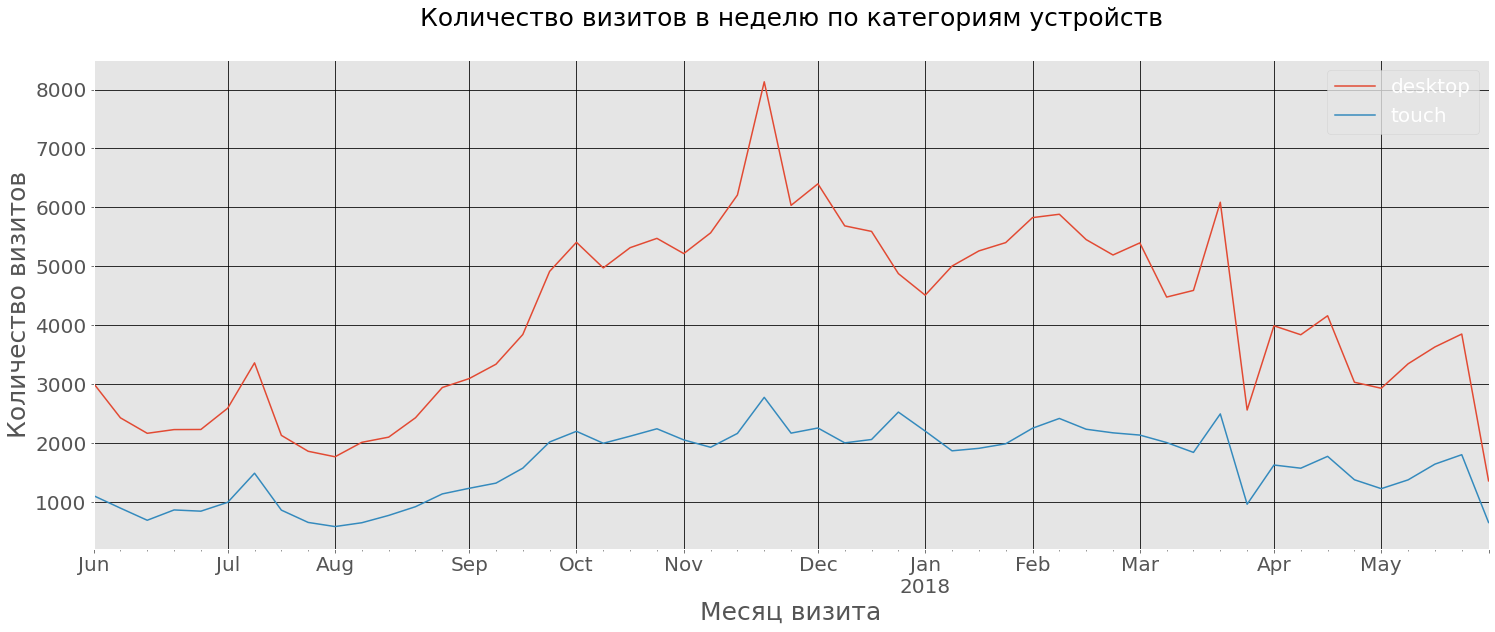

Визитов на сайт уникальных пользователей по десктопу: dau: 659 , wau: 4136 , mau: 16725
Визитов на сайт уникальных пользователей по touch: dau: 253 , wau: 1637 , mau: 6826


In [12]:
# посмотрим, как количество визитов зависит от категории устройств
df_visits.pivot_table(
                             index='dt_start_of_session_week', values='uid', 
                             columns='device_cat', aggfunc='nunique'
).\
plot(figsize = (25, 9))
plt.title('Количество визитов в неделю по категориям устройств' + '\n', fontsize = 25, color='black')
plt.legend(prop={'size': 20})
plt.ylabel('Количество визитов', fontsize = 25)
plt.xlabel('Месяц визита', fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.grid(c='black')
plt.show()

# создадим переменные с визитами по категориям устройств
visits_desktop = df_visits.query('device_cat == "desktop"')
visits_touch = df_visits.query('device_cat == "touch"')

# посчитаем engagement metrics для десктопа    
desktop_dau = visits_desktop.groupby('dt_start_of_session_day')['uid'].\
nunique().mean().round().astype(int)
desktop_wau = visits_desktop.groupby('dt_start_of_session_week')['uid'].\
nunique().mean().round().astype(int)
desktop_mau = visits_desktop.groupby('dt_start_of_session_month')['uid'].\
nunique().mean().round().astype(int)

# посчитаем engagement metrics для мобильной версии устройств 
touch_dau = visits_touch.groupby('dt_start_of_session_day')['uid'].\
nunique().mean().round().astype(int)
touch_wau = visits_touch.groupby('dt_start_of_session_week')['uid'].\
nunique().mean().round().astype(int)
touch_mau = visits_touch.groupby('dt_start_of_session_month')['uid'].\
nunique().mean().round().astype(int)

# посмотрим на полученные результаты
print('\033[1m' + 'Визитов на сайт уникальных пользователей по десктопу:' + '\033[0m', 'dau:' , 
      desktop_dau, ', wau:', desktop_wau, ', mau:', desktop_mau)
print('\033[1m' + 'Визитов на сайт уникальных пользователей по touch:'+'\033[0m',
      'dau:', touch_dau, ', wau:', touch_wau, ', mau:', touch_mau)

Видим ожидаемую картину. **Визитов с десктопной версии гораздо больше, чем с мобильной**. Это не удивляет - около 3/4 всех визитов приходятся на десктопную версию. 

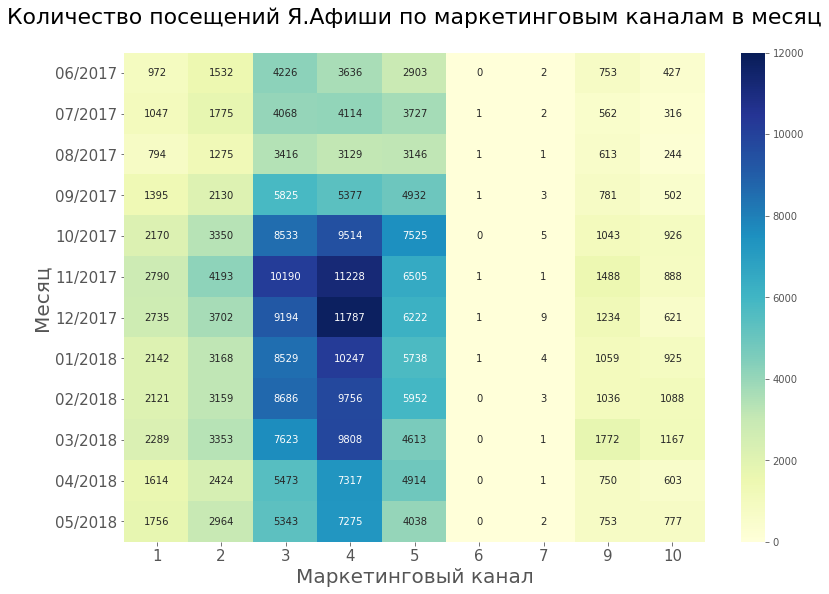

In [13]:
# посмотрим на количество уникальных пользователей, приходящих на 
# Я.Афишу через разные маркетинговые каналы 
mau_pivot = df_visits.pivot_table(
                                  index='dt_start_of_session_month', values='uid',
                                  columns='commercial_source_id', aggfunc='nunique'
).\
fillna(0).astype(int)

# построим heatmap
plt.figure(figsize=(13,9))
mau_pivot_with_index = mau_pivot.copy()
mau_pivot_with_index.index = mau_pivot_with_index.index.strftime('%m/%Y')
sns.heatmap(mau_pivot_with_index, cmap="YlGnBu", annot=True, vmin=0,
            vmax=12000, fmt='d')
plt.title('Количество посещений Я.Афиши по маркетинговым каналам в месяц' + '\n', 
          fontsize=22, color='black')
plt.ylabel('Месяц', fontsize=20)
plt.xlabel('Маркетинговый канал', fontsize=20)
plt.yticks( fontsize = 15, rotation=0)
plt.xticks(fontsize = 15)
plt.show()

Больше всего потенциальных покупателей заходят к нам с третьего и четвертого маркетинговых каналов. На данном графике так же просматривается, что у нашего продукта есть сезонность - наибольшее количество посетителей к нам приходят в ноябре и декабре. 

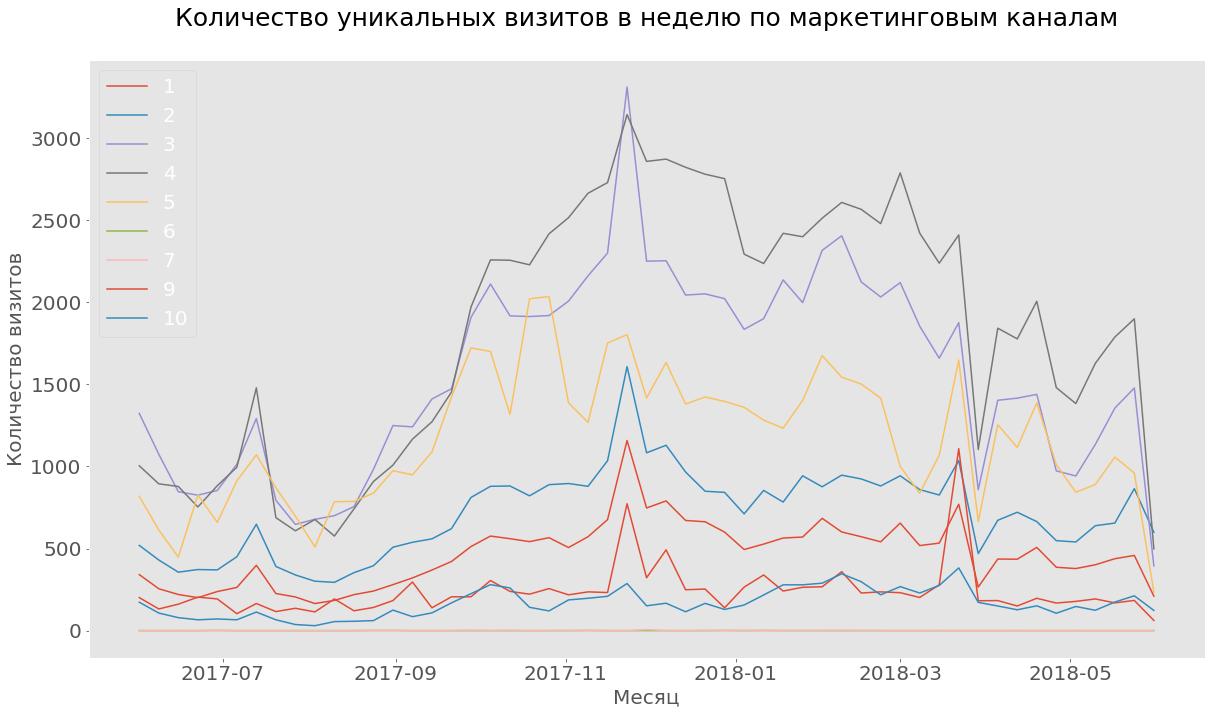

In [14]:
# посмотрим на динамику изменения количества уникальных пользователей по маркетинговым каналам
plt.style.use('ggplot')
wau_pivot = df_visits.pivot_table(
                                  index='dt_start_of_session_week', values='uid', 
                                  columns='commercial_source_id', aggfunc='nunique'
).\
fillna(0).astype(int)

# построим график
plt.figure(figsize=(20,11))
plt.title('Количество уникальных визитов в неделю по маркетинговым каналам' + '\n', 
          fontsize = 25, color='black')
plt.plot(wau_pivot)
plt.legend(wau_pivot.columns, loc=0, prop={'size': 20})
plt.xlabel('Месяц', fontsize=20)
plt.ylabel('Количество визитов', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()

## Общие выводы по вопросу:
- у нашего продукта есть сезонность, в ноябре и декабре покупают больше, чем в другие месяцы. В январе - затишье. 
- 3/4 потенциальных покупателей заходят на сайт с десктопной версии, 1/4 - с мобильной и лишь 1/50 с обоих устройств. 
- возможно, что пользователи , которые заходят с мобильного приложения не подвержены указанной выше сезонности. Но это лишь гипотеза, для ответа на этот вопрос нужны еще данные. 
- у Я.Афиши есть небольшая пользовательская база, но большинство пользователей не задерживаются в приложении
- больше всех визитов на сайт приходят через маркетинговые каналы 3 и 4 

# Сколько сессий совершает средний пользователь в день?

Статистика количества сессий в день:


,uid
count,364.000
mean,987.000
std,419.000
min,1.000
25%,636.000
50%,1003.000
75%,1280.000
max,4042.000


Средний пользователь совершает 1.09 сессий в день


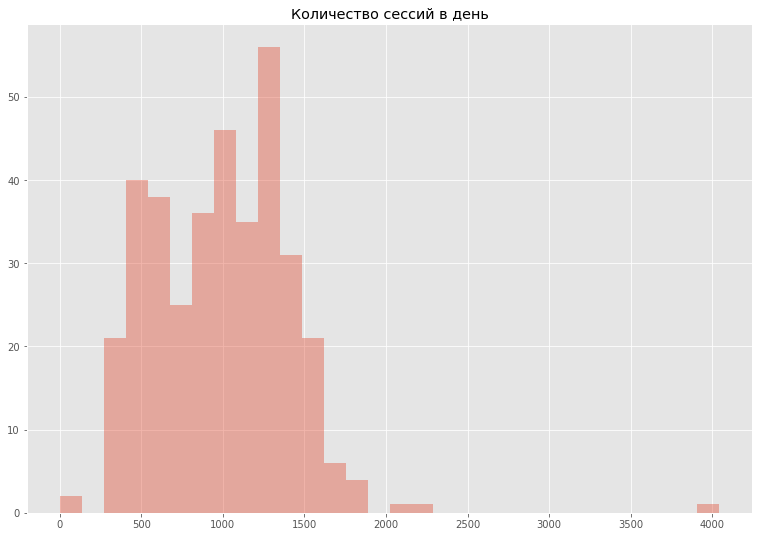

In [15]:
# посчитаем количество сессий на пользователя 
def count_sessions_per_day(df):
    '''Считает количество сессий в день, выводит describe и гистограмму
    df - датафрейм, который функцию берет на вход
    '''
    print('Статистика количества сессий в день:')
    display(round(df.groupby(['dt_start_of_session_year', 
                              'dt_start_of_session_day']).agg({'uid':'count'})\
                  .describe()))
    print('Средний пользователь совершает {:.2f} сессий в день'.\
          format(df.groupby(['dt_start_of_session_year', 
                             'dt_start_of_session_day'])['uid'].count().mean() / 
                df.groupby(['dt_start_of_session_year', 
                            'dt_start_of_session_day'])['uid'].nunique().mean()))
    
# теперь построим гистограмму    
    plt.figure(figsize=(13,9))
    sns.distplot(df.groupby(['dt_start_of_session_year', 
                             'dt_start_of_session_day']).agg({'uid':'count'}), 
            bins=30, kde=False)
    plt.title('Количество сессий в день', color='black')
    plt.show()
count_sessions_per_day(df_visits)

desktop
Статистика количества сессий в день:


,uid
count,364.000
mean,721.000
std,322.000
min,1.000
25%,457.000
50%,711.000
75%,962.000
max,3152.000


Средний пользователь совершает 1.09 сессий в день


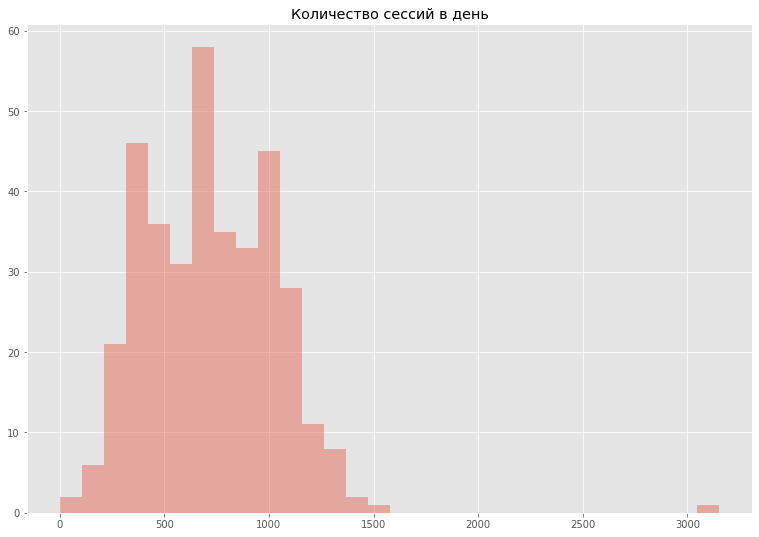

touch
Статистика количества сессий в день:


,uid
count,363.000
mean,267.000
std,111.000
min,47.000
25%,181.000
50%,278.000
75%,337.000
max,890.000


Средний пользователь совершает 1.05 сессий в день


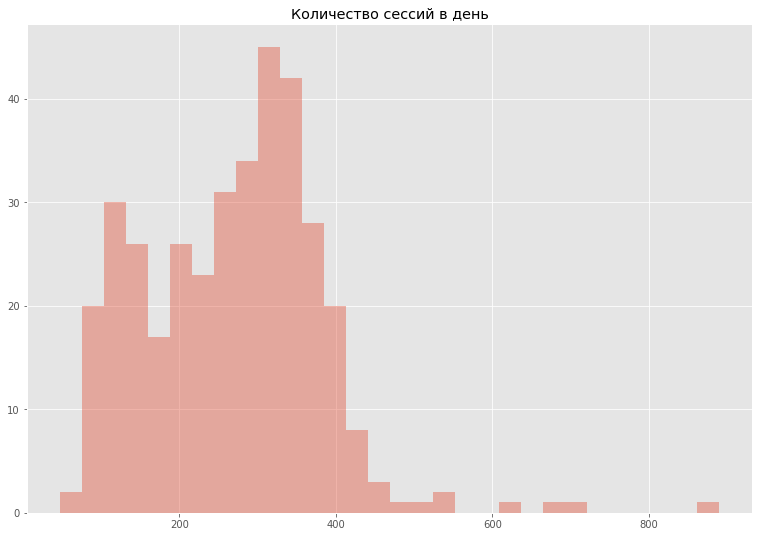

In [16]:
for device in ['desktop', 'touch']:
    print('\033[1m' + device + '\033[0m')
    count_sessions_per_day(df_visits.query('device_cat==@device'))

## Общие выводы по вопросу:

В среднем пользователи совершают **1 сессию** на сайте Яндекс Афиши. Но **этот показатель чуть ниже для мобильной версии** сайта. Возможно, у Яндекс Афиши нет удобного мобильного приложения. 

# Сколько длится одна сессия?

count   359400.000
mean       643.125
std        997.068
min      -2760.000
25%        120.000
50%        300.000
75%        840.000
max      42660.000
Name: session_length_seconds_total, dtype: float64

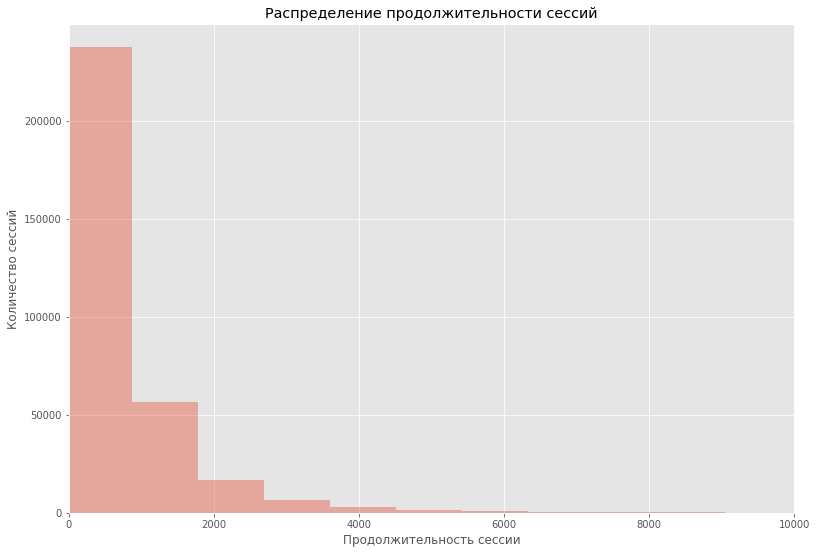

2

0

Мода сессии по двум типам устройств составляет 60 секунд
count   323606.000
mean       714.290
std       1026.282
min         60.000
25%        120.000
50%        360.000
75%        900.000
max      42660.000
Name: session_length_seconds_total, dtype: float64


In [17]:
# Из описания данных нам известно, что у нас много сессий продолжительностью в 19 секунд. 
# Округлим их до минуты
df_visits['dt_start_of_session'] = pd.to_datetime(df_visits['dt_start_of_session'])
df_visits['dt_start_of_session'] = df_visits['dt_start_of_session'].dt.ceil('1T')
df_visits['dt_end_of_session'] = df_visits['dt_end_of_session'].dt.ceil('1T')

# для начала узнаем, есть ли у нас ошибки в данных, а именно отрицательные сессии
df_visits['session_length_seconds_total'] = (df_visits['dt_end_of_session'] - 
                                             df_visits['dt_start_of_session']).\
dt.total_seconds()
display(df_visits['session_length_seconds_total'].describe())

# видим, что у нас есть значения, которые равны нулю. Скорее всего, это может 
# объясняться особенностями браузеров и расширений, которые 
# устанавливают пользователи. Для нас такие сессии не репрезентативны, потому что 
# не говорят нам ничего о центральной тенденции распределения. 
# Удалим их и посмотрим на распределение 
session_length_no_zeros = df_visits.query('session_length_seconds_total != 0')
plt.figure(figsize=(13,9))
sns.distplot(session_length_no_zeros['session_length_seconds_total'], kde=False)
plt.xlim(0, 10000)
plt.title('Распределение продолжительности сессий', c='black')
plt.xlabel('Продолжительность сессии')
plt.ylabel('Количество сессий')
plt.show()

# помимо этого видим, что минимальное значение у нас -2760,  
# посмотрим сколько у нас отрицательных значений 
display(session_length_no_zeros['session_length_seconds_total']\
            [session_length_no_zeros['session_length_seconds_total'] < 0].count())

# у нас есть два отрицательных значений, поговорить с разработчиками не 
# представляется возможным, поэтому приведем их к модулю методом abs()
session_length_no_zeros['session_length_seconds_total'] = \
session_length_no_zeros['session_length_seconds_total'].abs()
display(session_length_no_zeros['session_length_seconds_total']\
        [session_length_no_zeros['session_length_seconds_total'] < 0].count())

# еще раз проверим себя и посмторим, есть ли в данных сессии с ошикой фиксации их продолжения
abnormal_sessions = session_length_no_zeros['dt_end_of_session'] < \
session_length_no_zeros['dt_start_of_session']
abnormal_sessions.value_counts()
# таких сессий только две, мы уже от них избавились с помощью метода abs()

# распределение данного признака далеко от нормального, поэтому представляется, 
# что репрезентативной мерой средней тенденции в данном случае может быть мода. 
# Посмотрим на нее. 
print('Мода сессии по двум типам устройств составляет', int(
    session_length_no_zeros['session_length_seconds_total'].\
    mode().round(2)), 'секунд')
print(session_length_no_zeros['session_length_seconds_total'].describe())

### Выводы: 
- получили, что **мода нашего распределения составляет 1 минуту**. Возможно ли такое, что пользователи проводят в среднем на сайте 1 минуту?
- **возможно, что для нашего распределения репрезентативной мерой центральной тенденции будет медиана, которая составляет 6 минут.** 
- в данной ситуации однозначный вывод сделать довольно трудно. Представляется, для полного понимания ситуации нужно идти к разработчикам и узнавать, как 
    именно загружаются данные и может ли какое-нибудь разрешение в браузере быть ответственным за то, что мы получаем такую моду. 
- у нас нет возможности пойти к разработчикам, поэтому сделаем допущение, что в данных действительно ошибка и короткие сессии можно не учитывать при подсчете типичной длины сессии. Тогда уберем все 60 секундные сессии из данных, посмотрим на распределение и выберем наиболее репрезентативную меру центральной тенденции и посчитаем ее.

count   269707.000
mean       845.028
std       1077.534
min        120.000
25%        240.000
50%        480.000
75%       1080.000
max      42660.000
Name: session_length_seconds_total, dtype: float64


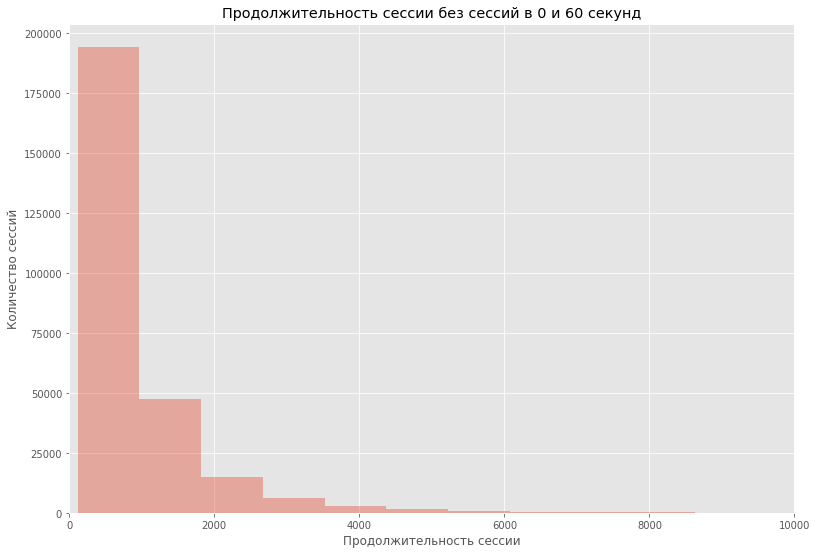

count   269707.000
mean       845.028
std       1077.534
min        120.000
25%        240.000
50%        480.000
75%       1080.000
max      42660.000
Name: session_length_seconds_total, dtype: float64

In [18]:
# создадим переменную session_length_new, в которой не будет сессий продолжительностью 0 и 60 секунд. 
df_visits['session_length_seconds_total'] = df_visits['session_length_seconds_total'].\
astype(int)
session_length_new = df_visits.query('session_length_seconds_total != 0 \
and session_length_seconds_total != 60 and session_length_seconds_total > 0')
print(session_length_new['session_length_seconds_total'].describe())
plt.figure(figsize=(13,9))
sns.distplot(session_length_new['session_length_seconds_total'], kde=False)
plt.xlim(0, 10000)
plt.title('Продолжительность сессии без сессий в 0 и 60 секунд', c='black')
plt.xlabel('Продолжительность сессии')
plt.ylabel('Количество сессий')
plt.show()
session_length_new['session_length_seconds_total'].describe()

### Выводы: 
- нельзя сказать, что распределение сильно поменялось, оставляем предыдущие меры центральной тенденции. 
- **Мода средней продолжительности сессии - 60 секунд, медиана - 360 секунд**

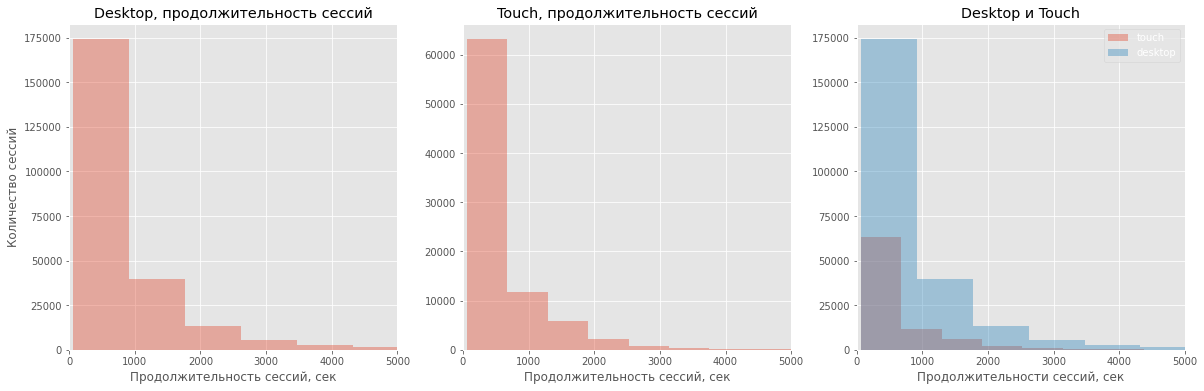

In [19]:
# посмотрим на продолжительность сессий по категориям устройств 
session_length_no_zeros_desktop = session_length_no_zeros.query(
    'device_cat =="desktop"')
session_length_no_zeros_touch = session_length_no_zeros.query(
    'device_cat =="touch"')
names = ['Desktop, продолжительность сессий', 'Touch, продолжительность сессий',
        'Desktop и Touch']


# построим графики
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(6)

sns.distplot(session_length_no_zeros_desktop['session_length_seconds_total'], 
            kde=False, ax=ax[0])
ax[0].set_xlim(0,5000)
ax[0].set_title(names[0], c='black')
ax[0].set_xlabel('Продолжительность сессий, сек')
ax[0].set_ylabel('Количество сессий')

sns.distplot(session_length_no_zeros_touch['session_length_seconds_total'], 
            kde=False, ax=ax[1])
ax[1].set_xlabel('Продолжительность сессий, сек')
ax[1].set_title(names[1], c='black')
ax[1].set_xlim(0,5000)


sns.distplot(session_length_no_zeros_touch['session_length_seconds_total'],
            kde=False, ax=ax[2], label='touch')
sns.distplot(session_length_no_zeros_desktop['session_length_seconds_total'], 
            kde=False, ax=ax[2], label='desktop')
ax[2].set_title(names[2], c='black')
ax[2].set_xlabel('Продолжительности сессий, сек')
ax[2].set_xlim(0,5000)
plt.legend()
plt.show()

In [20]:
# теперь посчитаем описательную статистику
print('Мода продолжительности сессии для десктопной категории устройств \
составляет', int(session_length_no_zeros_desktop['session_length_seconds_total'].\
                 mode()))
print('Описательная статистика продолжительности сессии для','\033[1m'+ \
      'десктопной категории устройств:' + '\033[0m') 
display(session_length_no_zeros_desktop['session_length_seconds_total'].describe())
print(' ')
print('-----------------------------------------------------------\
--------------------')
print(' ')
print('Мода продолжительности сессии для мобильной категории устройств \
составляет', int(session_length_no_zeros_desktop['session_length_seconds_total'].\
                 mode()))
print('Описательная статистика продолжительности сессии для','\033[1m'+ '\
мобильной категории устройств:' + '\033[0m')
display(session_length_no_zeros_touch['session_length_seconds_total'].describe())

Мода продолжительности сессии для десктопной категории устройств составляет 60
Описательная статистика продолжительности сессии для десктопной категории устройств:


count   238878.000
mean       773.184
std       1094.254
min         60.000
25%        120.000
50%        420.000
75%       1020.000
max      42660.000
Name: session_length_seconds_total, dtype: float64

 
-------------------------------------------------------------------------------
 
Мода продолжительности сессии для мобильной категории устройств составляет 60
Описательная статистика продолжительности сессии для мобильной категории устройств:


count   84728.000
mean      548.246
std       780.734
min        60.000
25%       120.000
50%       240.000
75%       720.000
max     30840.000
Name: session_length_seconds_total, dtype: float64

## Выводы

Мы посчитали и моду, и медиану для данного вопроса. Тем не менее **мы все еще не можем сказать, какая мера центральной тенденции более репрезентативна для нас**. Скорее всего в данных есть ошибка из-за которой много сессий отмечены короткой продолжительностью - тогда для нас подойдет медиана. Да и здравый смысл подсказывает, что за минуту трудно успеть что-то посмотреть, а тем более купить на сайте.

# Как часто люди возвращаются?

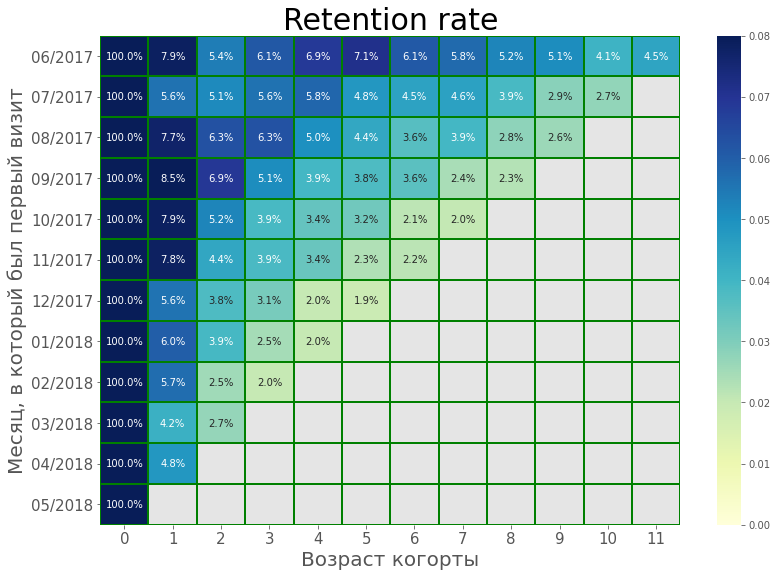

In [21]:
# посчитаем retention rate
def get_month(x): return dt.datetime(x.year, x.month, 1)
df_visits['visit_month'] = df_visits['dt_start_of_session'].apply(get_month)
grouping = df_visits.groupby('uid')['visit_month']
df_visits['cohort_month'] = grouping.transform('min')

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

def count_retention(df):
    visit_year, visit_month, _ = get_date_int(df, 'visit_month')
    cohort_year, cohort_month, _ = get_date_int(df, 'cohort_month')
    year_diff = visit_year - cohort_year
    month_diff = visit_month - cohort_month
    df['cohort_index'] = year_diff * 12 + month_diff    
    grouping = df.groupby(['cohort_month', 'cohort_index'])
    cohort_data = grouping['uid'].apply(pd.Series.nunique)
    cohort_data = cohort_data.reset_index()
    cohort_counts = cohort_data.pivot_table(index='cohort_month', 
                                            columns='cohort_index', values='uid')
    cohort_sizes = cohort_counts.iloc[:, 0]
    retention = cohort_counts.divide(cohort_sizes, axis=0)
    retention.round(4) * 100
    retention.index = retention.index.strftime("%m/%Y")
    return retention

# построим heatmap    
plt.figure(figsize=(13, 9))    
sns.heatmap(count_retention(df_visits), annot=True, fmt='.1%', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin=0, vmax=0.08)
plt.ylabel('Месяц, в который был первый визит', fontsize=20)
plt.xlabel('Возраст когорты', fontsize=20)
plt.title('Retention rate', fontsize=30, c='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

In [22]:
print('Средний Retention Rate по когорте от 07/2017 составляет {:.1%}'.\
      format(count_retention(df_visits).loc['07/2017', 1:].dropna().mean().\
             mean().round(3)))
print('Динамика изменения Retention Rate со второго по шестой месяца жизней когорт:')
for i in range(1,6):
    print(count_retention(df_visits).loc[:, i].dropna().mean().mean().round(2))

Средний Retention Rate по когорте от 07/2017 составляет 4.6%
Динамика изменения Retention Rate со второго по шестой месяца жизней когорт:
0.07
0.05
0.04
0.04
0.04


Важно заметить, что retention rate первой когорты немного выше, чем всех остальных. Вероятно, что еще одна полезная форма ответа на вопрос о rr будет заключаться в одной цифре. Поскольку первая когорта у нас немного "аномальная", возьмем вторую которту и рассчитаем для нее средний rr, начиная со второго месяца.  

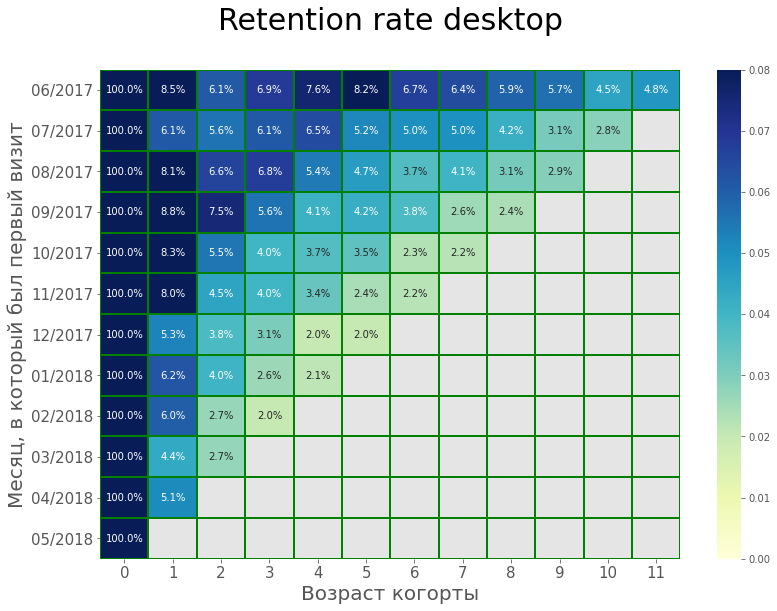

In [23]:
# теперь посчитаем RR для категорий устройств 
df_visits_desktop = df_visits.query('device_cat == "desktop"')
plt.figure(figsize=(13, 9))    
sns.heatmap(count_retention(df_visits_desktop), annot=True, fmt='.1%', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin=0, vmax=0.08)
plt.ylabel('Месяц, в который был первый визит', fontsize=20)
plt.xlabel('Возраст когорты', fontsize=20)
plt.title('Retention rate desktop' + '\n', fontsize=30, c='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

In [24]:
print('Средний Retention Rate по когорте от 07/2017 по десктопной категории\
составляет {:.1%}'.\
      format(count_retention(df_visits_desktop).loc['07/2017', 1:].\
             dropna().mean().mean().round(3)))
print('Динамика изменения Retention Rate со второго по шестой месяца жизней когорт:')
for i in range(1,6):
    print(count_retention(df_visits_desktop).loc[:, i].dropna().mean().\
          mean().round(2))

Средний Retention Rate по когорте от 07/2017 по десктопной категориисоставляет 5.0%
Динамика изменения Retention Rate со второго по шестой месяца жизней когорт:
0.07
0.05
0.05
0.04
0.04


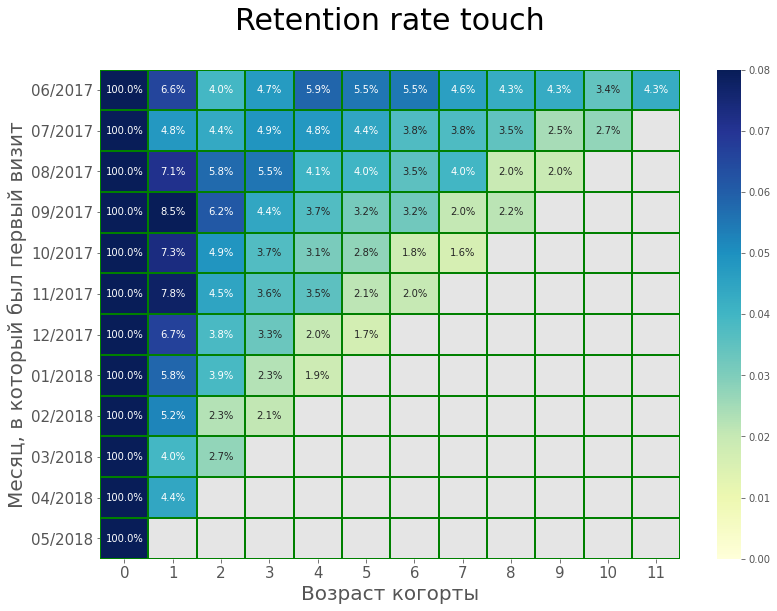

In [25]:
df_visits_touch = df_visits.query('device_cat == "touch"')
plt.figure(figsize=(13, 9))    
sns.heatmap(count_retention(df_visits_touch), annot=True, fmt='.1%', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin=0, vmax=0.08)
plt.ylabel('Месяц, в который был первый визит', fontsize=20)
plt.xlabel('Возраст когорты', fontsize=20)
plt.title('Retention rate touch' + '\n', fontsize=30, c='black')
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

In [26]:
print('Средний Retention Rate по когорте от 07/2017 по мобильной \
категории составляет {:.1%}'.\
      format(count_retention(df_visits_touch).loc['07/2017', 1:].dropna().\
             mean().mean().round(3)))
print('Динамика изменения Retention Rate со второго по шестой месяца жизней когорт:')
for i in range(1,6):
    print(count_retention(df_visits_touch).loc[:, i].dropna().mean().mean().round(2))

Средний Retention Rate по когорте от 07/2017 по мобильной категории составляет 4.0%
Динамика изменения Retention Rate со второго по шестой месяца жизней когорт:
0.06
0.04
0.04
0.04
0.03


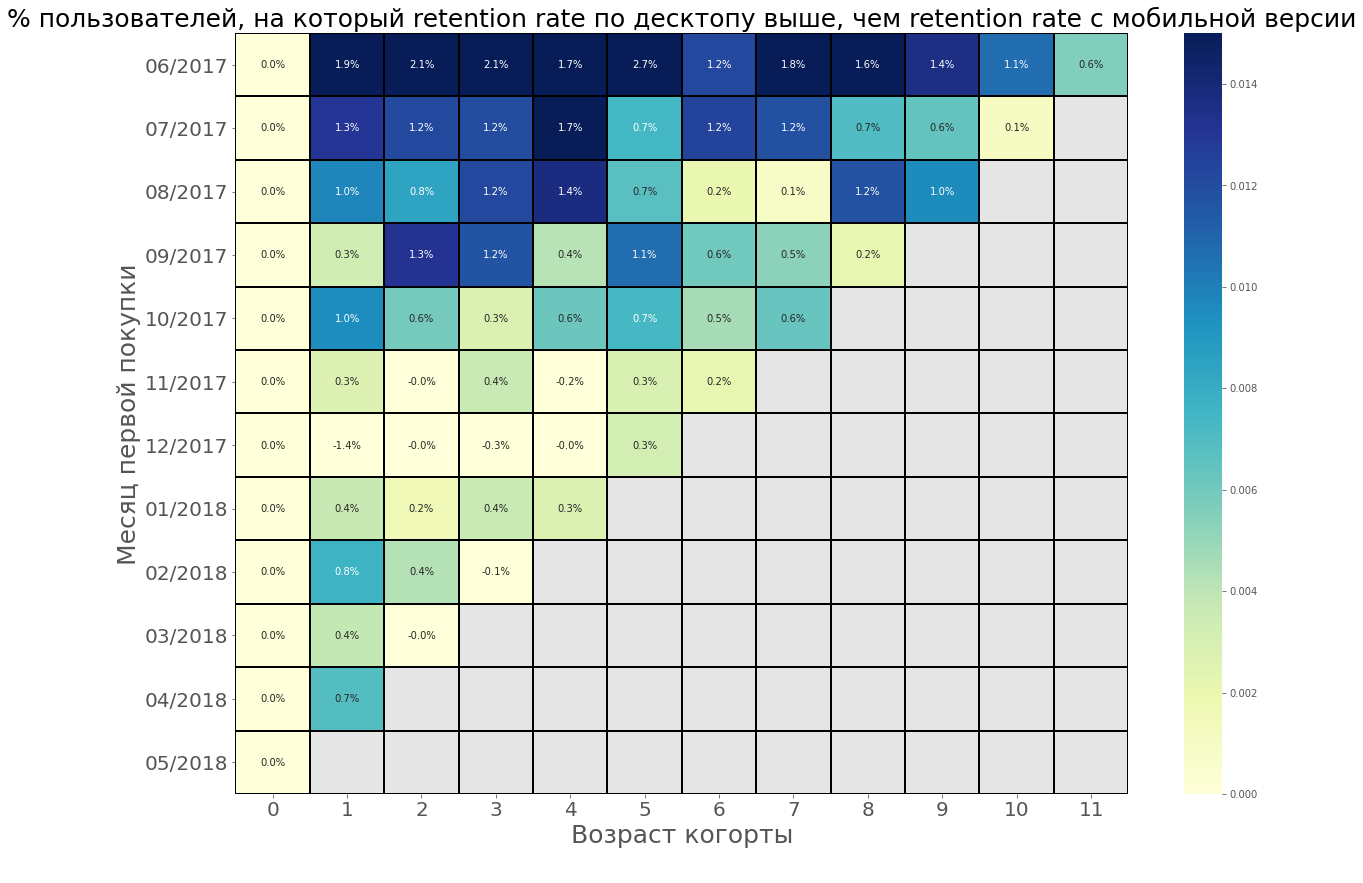

In [27]:
diff_between_retentions = count_retention(df_visits_desktop) - \
count_retention(df_visits_touch)
plt.figure(figsize=(20,14))
sns.heatmap(diff_between_retentions, annot=True, fmt='.1%', linewidth=1, 
            linecolor='black', cmap='YlGnBu', vmin=0, vmax=0.015)
plt.title('% пользователей, на который retention rate по десктопу выше, чем \
retention rate с мобильной версии', 
          fontsize=25, c='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20, rotation=0)
plt.xlabel('Возраст когорты'+ '\n', fontsize=25)
plt.ylabel('Месяц первой покупки', fontsize=25)
plt.show()

In [28]:
diff_between_retentions_mean = diff_between_retentions.mean()
diff_between_retentions_mean.mean()
print('В среднем retention rate пользователей, использующий десктопную версию \
выше на {:.1%}, чем у пользователей, использующий мобильную версию Яндекс Афиши.'.\
      format(diff_between_retentions_mean.mean().round(3)))

В среднем retention rate пользователей, использующий десктопную версию выше на 0.7%, чем у пользователей, использующий мобильную версию Яндекс Афиши.


## Выводы
- средний retention rate составляет 4.6%
- retention rate у пользователей, использующих десктопную версию на 0.7% выше, чем у пользователей, который заходят на сайт с мобильной версии. 

# Когда люди начинают покупать?

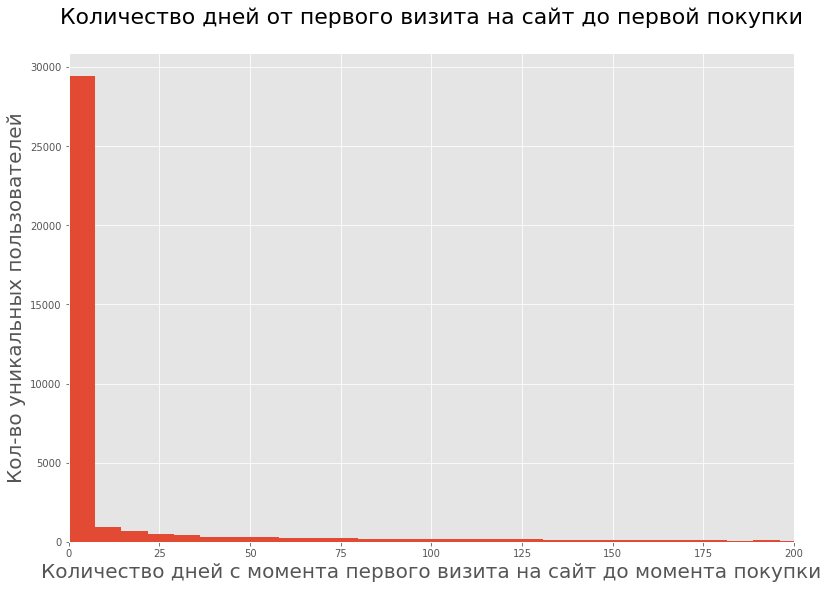

Мода среднего количества дней по двум категориям устройств составляет 0
Мода среднего количества дней по десктопной версии составляет 0
Мода среднего количества дней по мобильной версии составляет 0


In [29]:
# посчитаем количество дней от первого визита на сайт до первой покупки 
first_session = df_visits.groupby('uid')['dt_start_of_session'].min()
first_session.name = 'first_session'
df_visits = df_visits.merge(first_session, on='uid')
first_visit = df_visits[['uid', 'first_session', 'device_cat', 
                         'commercial_source_id']].reset_index()
first_visit = first_visit.sort_values(by='first_session')
first_visit = first_visit.groupby('uid')[['first_session', 'device_cat', 
                                          'commercial_source_id']].\
first().reset_index()
first_purchase = df_orders.groupby('uid')['dt_of_order'].min().reset_index()
time_to_first_purchase = first_visit.merge(first_purchase, on='uid', how='right')

time_to_first_purchase['time_to_first_purchase'] = pd.to_timedelta(
    (time_to_first_purchase['dt_of_order'] - \
     time_to_first_purchase['first_session']).\
    dt.days, unit='d')/np.timedelta64(1, 'D')

# визуализируем
plt.figure(figsize=(13,9))
time_to_first_purchase['time_to_first_purchase'].hist(bins=50)
plt.xlim(0,200)
plt.xlabel('Количество дней с момента первого визита на сайт до момента покупки',
           fontsize=20)
plt.ylabel('Кол-во уникальных пользователей', fontsize=20)
plt.title('Количество дней от первого визита на сайт до первой покупки' + '\n', 
          fontsize=22, color='black')
plt.show()
# посмотрим, какая мода у этой метрики по категории устройств
print('Мода среднего количества дней по двум категориям устройств составляет', 
      int(time_to_first_purchase['time_to_first_purchase'].mode()))
time_to_first_purchase_desktop = time_to_first_purchase.query(
    'device_cat == "desktop"')
print('Мода среднего количества дней по десктопной версии составляет',
      int(time_to_first_purchase_desktop['time_to_first_purchase'].mode()))
time_to_first_purchase_touch = time_to_first_purchase.query(
    'device_cat == "touch"')
print('Мода среднего количества дней по мобильной версии составляет',
      int(time_to_first_purchase_touch['time_to_first_purchase'].mode()))

На графике видно, что большинство сессий длятся ноль дней, то же самое говорят нам моды данных. Здесь возможны два объяснения: 
- это баг в выгрузке данных 
- большинство пользователей покупают в первый день 


Можно проверить вторую гипотезу подсчитав кумулятивную сумму всех сессий и посмотреть процент пользователей, у которых будет одна сессия. Если у большинства пользователей будет одна сессия, то это станет весьма убедительным доказательством того, что большинство пользователей покупают в первый день. 

In [30]:
df_visits['num_of_session'] = df_visits.sort_values(
    ['uid','dt_start_of_session'], ascending=[True,True]) \
             .groupby(['uid']) \
             .cumcount() + 1
df_visits.sort_values(by=['uid', 'num_of_session'])
df_visits['num_of_session'].value_counts(normalize=True).head(10)

1    0.635
2    0.145
3    0.059
4    0.031
5    0.019
6    0.012
7    0.009
8    0.006
9    0.005
10   0.004
Name: num_of_session, dtype: float64

## Выводы

Получили распределение сумм количества сессий по пользователям. Получается, что 63.5 процента пользователей совершают на сайт Яндекс Афиши лишь один визит. 
Соответственно люди в среднем начинают покупать в свой первый день на сайте. 

# Сколько покупок совершают в месяц?

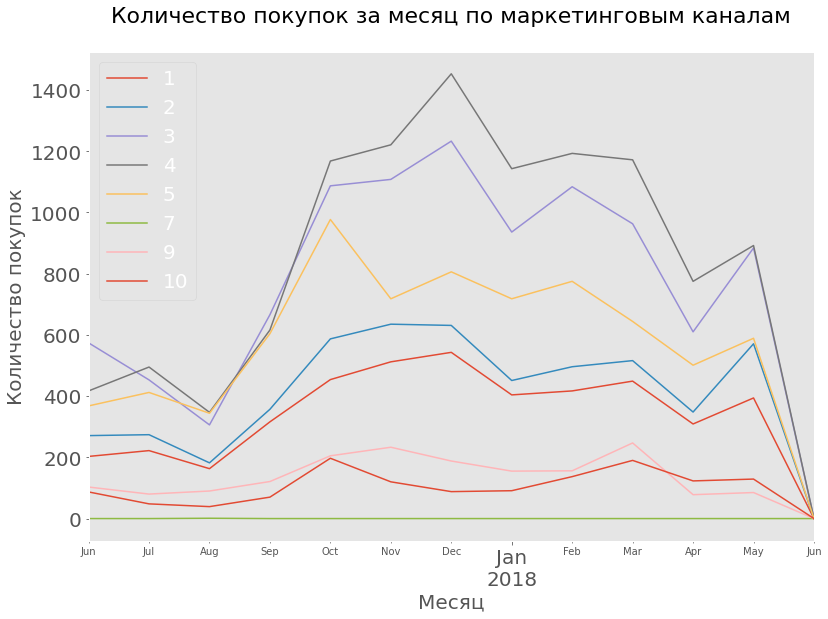

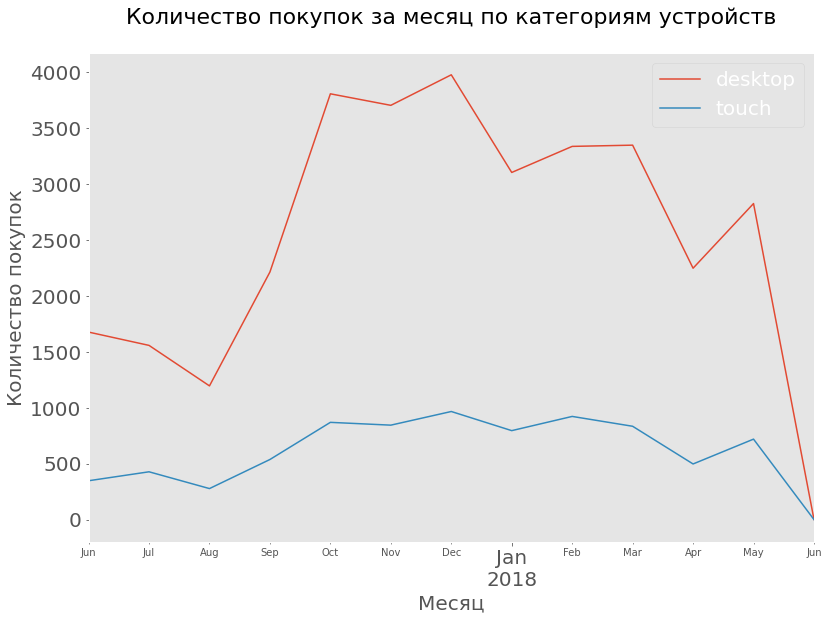

Среднее количество покупок в месяц составляет 3878
Среднее количество покупок в месяц по десктопу составляет 3146
Среднее количество покупок в месяц по мобильной версии составляет 792


In [31]:
# сколько раз покупают за месяц 
# посмотрим на количество покупок по маркетинговым каналам
first_source = df_visits.groupby(['uid'])[['commercial_source_id', 
                                           'device_cat']].first()
purchases = df_orders.merge(first_source, on='uid',
                        how='left')

purchases['order_month'] = purchases['dt_of_order'].\
astype('datetime64[M]')
purchases.pivot_table(index='order_month', values='uid', 
                                 columns='commercial_source_id', 
                                 aggfunc='nunique').\
fillna(0).astype(int).plot(figsize=(13,9))
plt.title('Количество покупок за месяц по маркетинговым каналам' + '\n', 
          fontsize=22, c='black')
plt.xlabel('Месяц', fontsize=20)
plt.ylabel('Количество покупок', fontsize=20)
plt.legend(loc=0, prop={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()


# построим график количества покупок по категориям устройств
purchases.pivot_table(index='order_month', values='uid', 
                                 columns='device_cat', aggfunc='nunique').\
fillna(0).astype(int).plot(figsize=(13, 9))
plt.title('Количество покупок за месяц по категориям устройств' + '\n', 
          fontsize=22, c='black')
plt.xlabel('Месяц', fontsize=20)
plt.ylabel('Количество покупок', fontsize=20)
plt.legend(loc=0, prop={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()

# посчитаем среднее количество покупок в месяц 
mean_number_of_purchases_by_month = purchases.groupby(
    'order_month')['uid'].count().mean()

# посчитаем среднее количество покупок в месяц для определенных устройств
number_of_purchases_by_month_desktop = purchases.query(
    'device_cat == "desktop"')
mean_number_of_purchases_by_month_desktop = \
number_of_purchases_by_month_desktop.groupby('order_month')['uid'].\
count().mean()
number_of_purchases_by_month_touch = purchases.query(
    'device_cat == "touch"')
mean_number_of_purchases_by_month_touch = number_of_purchases_by_month_touch.\
groupby('order_month')['uid'].count().mean()
print('Среднее количество покупок в месяц составляет', int(
    mean_number_of_purchases_by_month))
print('Среднее количество покупок в месяц по десктопу составляет', int(
    mean_number_of_purchases_by_month_desktop))
print('Среднее количество покупок в месяц по мобильной версии составляет', int(
    mean_number_of_purchases_by_month_touch))

In [32]:
# посчитаем, сколько приходится покупок на одного пользователя

# сгруппируем датафрейм с покупками по uid 
grouping_orders = purchases.groupby('uid')['order_month']

# создадим месяц первой покупки
purchases['cohort_month'] = grouping_orders.transform('min')
visit_year, visit_month, _ = get_date_int(purchases, 'order_month')
cohort_year, cohort_month, _ = get_date_int(purchases, 'cohort_month')
year_diff_orders = visit_year - cohort_year
month_diff_orders = visit_month - cohort_month
purchases['cohort_index'] = year_diff_orders * 12 + month_diff_orders
grouping_orders = purchases.groupby(['cohort_month', 'cohort_index'])
cohort_data_orders = grouping_orders['uid'].apply(pd.Series.nunique)
cohort_data_orders = cohort_data_orders.reset_index()
cohort_counts_orders = cohort_data_orders.pivot_table(index='cohort_month', 
                                                      columns='cohort_index', 
                                                     values='uid')
users_by_month = purchases.groupby('order_month').agg({'uid':'nunique'})
users_by_month.name = 'users_by_month'
purchases_by_month = purchases.groupby('order_month').agg({'uid':'count'})
purchases_by_month.name = 'purchases_by_month'
purchases_by_month_mean = purchases_by_month / users_by_month
purchases_by_month_mean.mean()
print('Наши пользователи в среднем совершают', float(purchases_by_month_mean.\
                                                     mean().round(2)), 
      'покупок в месяц')

Наши пользователи в среднем совершают 1.21 покупок в месяц


## Выводы

- пользователь в среднем совершает 1.2 покупки на нашем сайте. 
- пропорция покупателей с десктопной версии к покупателям с мобильной версии примерно сохранилась на уровне пропорции визитов. 

# Какой средний чек?

Средний чек составляет 5 тысяч рублей


4.999646930477041

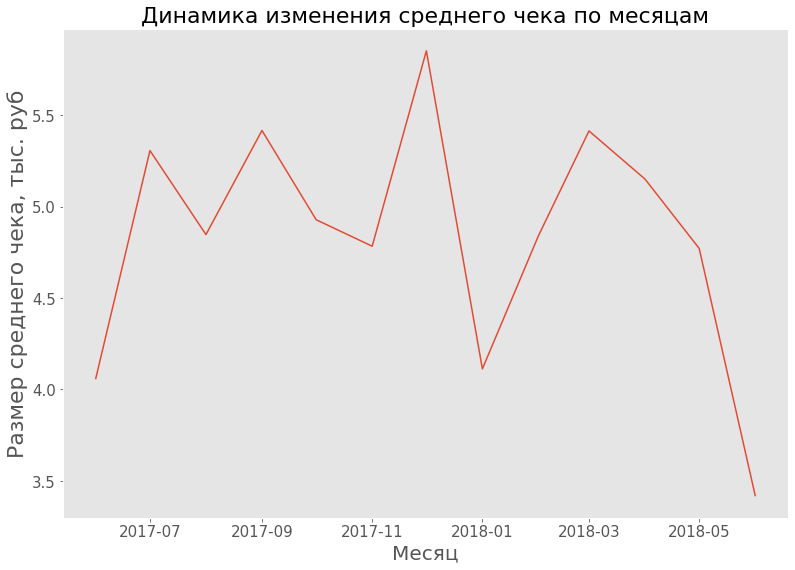

In [33]:
# средний чек
df_orders['month_of_order'] = df_orders['dt_of_order'].astype('datetime64[M]')
print('Средний чек составляет', int(df_orders['revenue'].mean().round()), 'тысяч рублей')
plt.figure(figsize=(13, 9))
plt.plot(df_orders.pivot_table(index='month_of_order', values='revenue', 
                               aggfunc='mean'))
plt.title('Динамика изменения среднего чека по месяцам', fontsize=22, c='black')
plt.xlabel('Месяц', fontsize=20)
plt.ylabel('Размер среднего чека, тыс. руб', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
df_orders['revenue'].mean()

## Выводы
Средний чек - 5 тысяч рублей. 
Наблюдая за средним чеком, можно отметить некоторую сезонность. В декабре наблюдается значительное увеличение среднего чека (возможно, что люди покупают подарки), в январе он резко падает, а марту все возвращается на круги своя. 

# Сколько денег приносят? (LTV)

In [34]:
df_orders_ltv = df_orders.copy()
df_orders_ltv['order_month'] = df_orders_ltv['dt_of_order'].\
astype('datetime64[M]')
first_orders = df_orders_ltv.groupby('uid').agg({'order_month': 'min'}).\
reset_index()
first_orders.columns = ['uid', 'first_order_month']
df_orders_ltv.dtypes
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid':'nunique'}).\
reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
orders_new = pd.merge(df_orders_ltv,first_orders, on='uid')
cohorts = orders_new.groupby(['first_order_month','order_month']).\
agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
margin_rate = 1
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / \
np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['n_buyers']

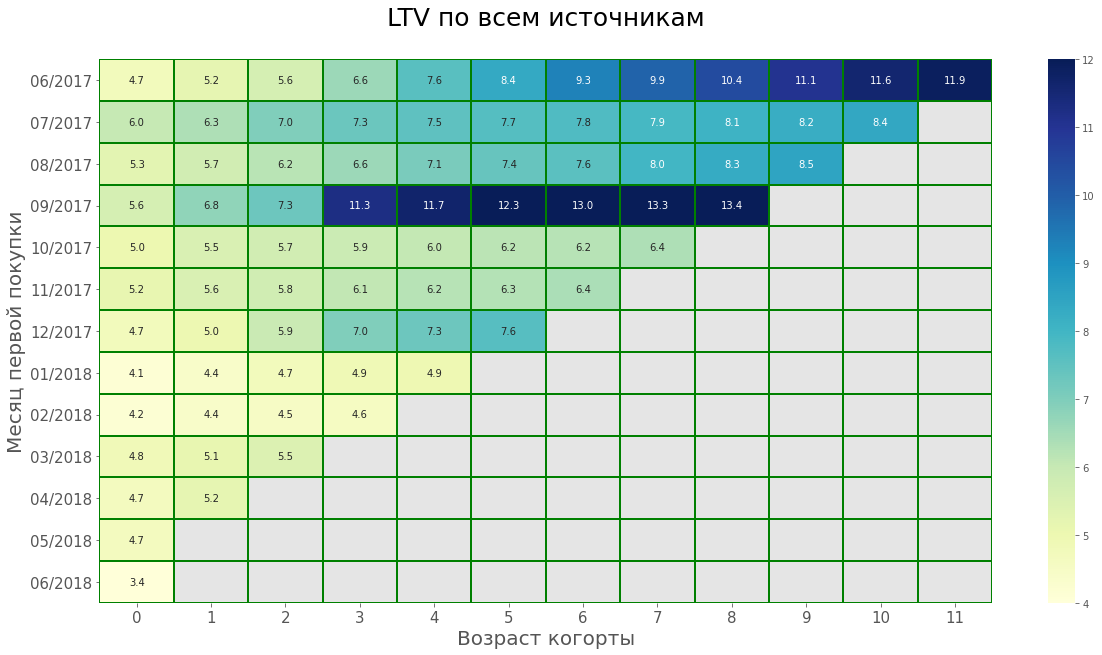

Средний ltv за шесть месяцев составляет 7.97


In [35]:
# визуализируем полученный результат 
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='sum').round(4)
output.fillna('')
output = output.cumsum(axis = 1)
output.index = output.index.strftime("%m/%Y")
plt.figure(figsize=(20, 10))
sns.heatmap(output, annot=True, fmt = '.1f', linewidths=1, linecolor='green', 
            cmap="YlGnBu", vmin = 4, vmax = 12)
plt.ylabel('Меcяц первой покупки', fontsize = 20)
plt.xlabel('Возраст когорты', fontsize = 20)
plt.title('LTV по всем источникам' + '\n', fontsize = 25, c='black')
plt.yticks(rotation = 0, fontsize = 15)
plt.xticks(fontsize = 15)
plt.show()

# примим за период жизни клиента 6 месяцев и рассчитаем средний ltv за это время
final_result = report.pivot_table( index='first_order_month', columns='age', 
                                  values='ltv', aggfunc='mean')
m6_cum_ltv = final_result.cumsum(axis=1).mean(axis=0)[5]
print('Средний ltv за шесть месяцев составляет', m6_cum_ltv.round(2))

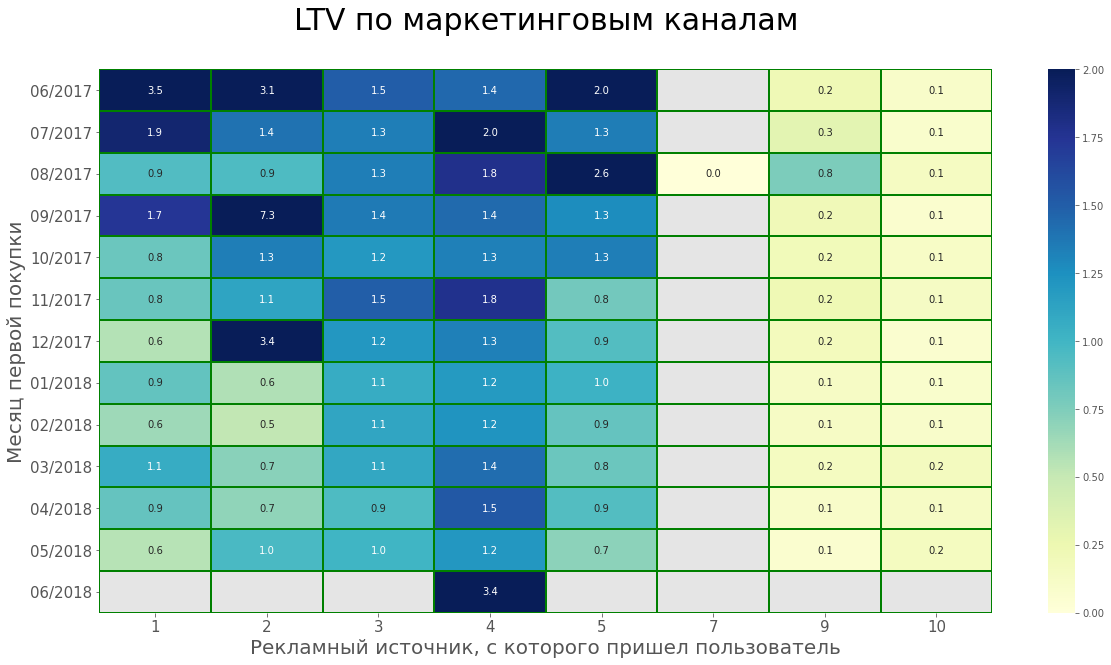

In [36]:
# Поскольку здесь нам потребуется иной способ группировки, не будем применять функцию, 
# которую написали ранее для расчета ltv по источника

visits_sources = df_visits.groupby('uid')['commercial_source_id'].first().\
reset_index()
df_visits
orders_sources = df_orders.merge(visits_sources, how = 'left', on = 'uid')
orders_sources
orders_sources['order_month'] = orders_sources['dt_of_order'].\
astype('datetime64[M]')
first_order_source = orders_sources.groupby('uid').agg({'order_month': 'min'}).\
reset_index()
first_order_source.columns = ['uid', 'first_order_month']
orders_sources
first_order_source
cohort_sizes = first_order_source.groupby('first_order_month').\
agg({'uid':'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
orders_source_new = pd.merge(orders_sources,first_order_source, on='uid')
cohorts_orders = orders_source_new.groupby(['first_order_month','order_month', 
                                            'commercial_source_id']).\
agg({'revenue': 'sum'}).reset_index()
report_source = pd.merge(cohort_sizes, cohorts_orders, on='first_order_month')
margin_rate = 1
report_source['gp'] = report_source['revenue'] * margin_rate
report_source['ltv'] = report_source['gp'] / report_source['n_buyers']


# визуализируем полученную таблицу 
output_source = report_source.pivot_table(index = 'first_order_month', 
                                          columns = 'commercial_source_id', 
                                          values = 'ltv', aggfunc = 'sum').round(4)
output_source.fillna('')
output_source.index = output_source.index.strftime("%m/%Y")
plt.figure(figsize=(20, 10))
sns.heatmap(output_source, annot=True, fmt = '.1f', linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin = 0, vmax = 2)
plt.ylabel('Меcяц первой покупки', fontsize = 20)
plt.xlabel('Рекламный источник, с которого пришел пользователь', fontsize = 20)
plt.title('LTV по маркетинговым каналам' + '\n', fontsize = 30, c='black')
plt.yticks(rotation = 0, fontsize = 15)
plt.xticks(fontsize = 15)
plt.show()

Из данного графика видно, что наибольшее ltv у марктинговых каналов под номерами 3 и 4. Однако помимо этого, можно обратить внимание на интересную деталь. LTV по второму источнику в сентябре и декабре очень высок. У нас явно недостаточно информации, чтобы понять с чем это может быть связано, но передадим маркетологам. 

## Выводы

- cредний ltv за шесть месяцев составляет 7.97
- LTV по второму источнику в сентябре и декабре аномально высок

# Сколько денег потратили? Всего / на каждый источник / по времени

В Яндекс Афише общая сумма, потраченная на маркетинг, за в период с 2017-06-01 00:00:00 до 2018-05-01 00:00:00 составляет 329131


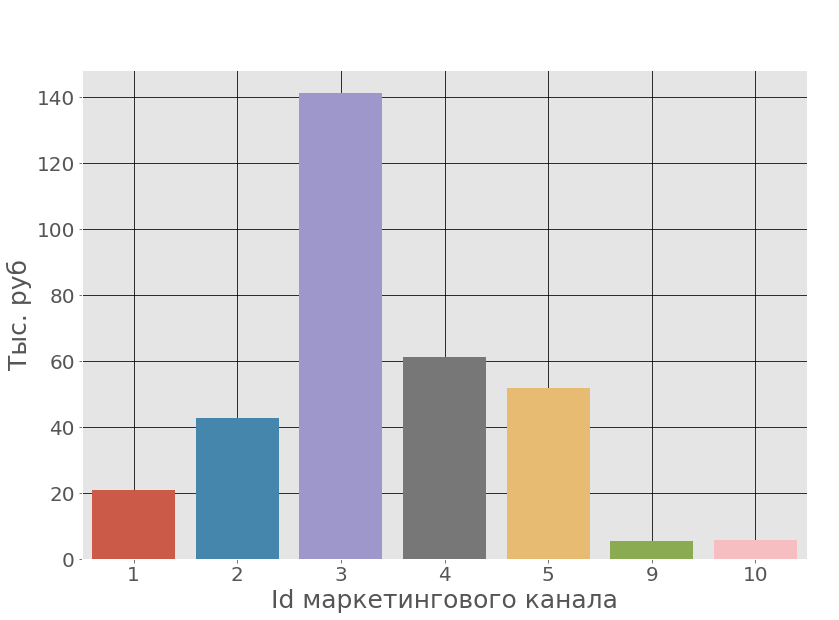

           cost_for_marketing_source
source_id                           
1                             20.833
2                             42.806
3                            141.322
4                             61.074
5                             51.757
9                              5.517
10                             5.822


In [37]:
# сколько денег потратили на маркетинг 
print('В Яндекс Афише общая сумма, потраченная на маркетинг, за в период с', 
      df_costs['month_of_commercial'].\
      min(), 'до', df_costs['month_of_commercial'].max(), 'составляет',
     int(df_costs['cost_for_marketing_source'].sum()))

df_costs_new = df_costs.copy()
df_costs_new.source_id = pd.Categorical(df_costs_new.source_id)
pivot_costs_sources_sum_new = df_costs_new.pivot_table(
                                        index='source_id', 
                                        values='cost_for_marketing_source', 
                                        aggfunc='sum')
pivot_costs_sources_sum_new['cost_for_marketing_source'] = \
pivot_costs_sources_sum_new['cost_for_marketing_source'] / 1000



plt.figure(figsize=(13, 9))
sns.barplot(x=pivot_costs_sources_sum_new.index, 
            y='cost_for_marketing_source', data=pivot_costs_sources_sum_new)
plt.title('Траты на маркетинг по маркетинговым каналам' + '\n', fontsize=30)
plt.xlabel('Id маркетингового канала', fontsize=25)
plt.ylabel('Тыс. руб', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(c='black')
plt.show()
print(pivot_costs_sources_sum_new)

In [38]:
# В предыдущем чанке мы увидели, что расходы составляют 329 тысяч. 
# На этом моменте будет справедливо задасться вопросом: 
# а рентабельный ли у нас проект в целом? Для ответа на этот вопрос посмотрим 
# на общую заработанную сумму. 
print('Общая сумма, на которую заказали пользователи составляет', 
      int(df_orders['revenue'].sum()))

Общая сумма, на которую заказали пользователи составляет 252057


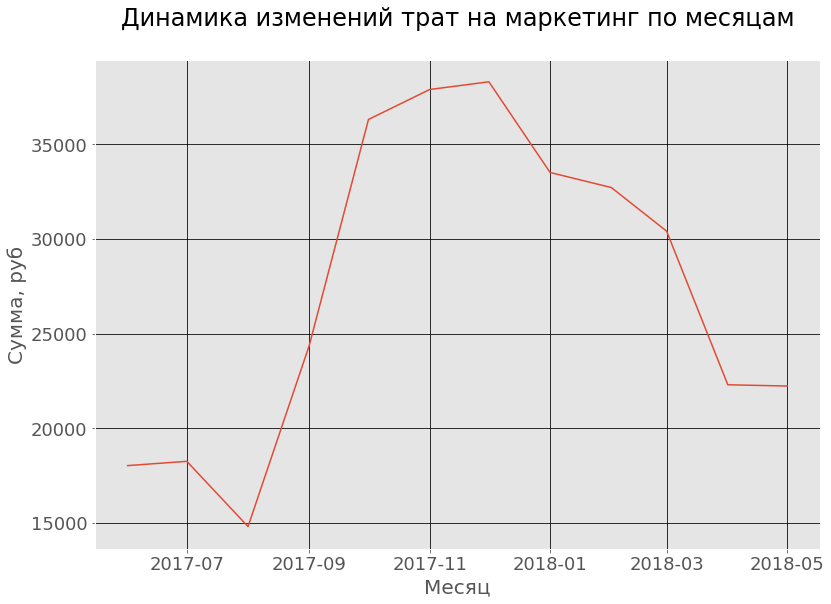

В месяц на маркетинг тратится в среднем 27427


In [39]:
plt.figure(figsize=(13,9))
plt.plot(df_costs.groupby('month_of_commercial')['cost_for_marketing_source'].sum())
plt.title('Динамика изменений трат на маркетинг по месяцам' + '\n', fontsize=24,
         c='black')
plt.xlabel('Месяц', fontsize=20)
plt.ylabel('Сумма, руб', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(c='black')
plt.show()
print('В месяц на маркетинг тратится в среднем', int(
            df_costs.groupby('month_of_commercial')['cost_for_marketing_source'].\
                                               sum().mean()))

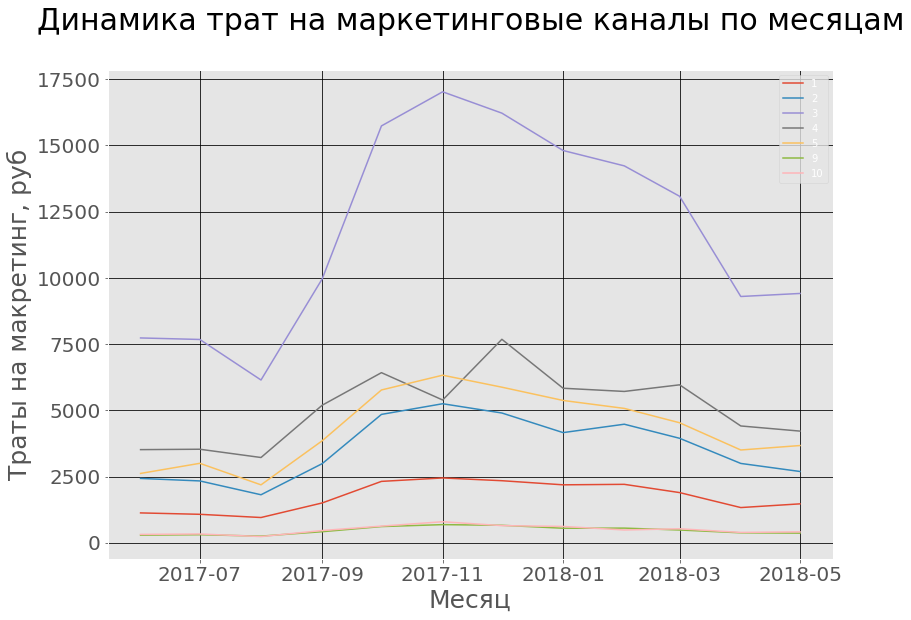

In [40]:
costs_pivot = df_costs.pivot_table(index='month_of_commercial', 
                                   values='cost_for_marketing_source', 
                                   columns='source_id', aggfunc='sum')
plt.figure(figsize=(13,9))
plt.plot(costs_pivot)
plt.legend(costs_pivot.columns)
plt.title('Динамика трат на маркетинговые каналы по месяцам' + '\n', fontsize=30,
         color='black')
plt.xlabel('Месяц', fontsize=25)
plt.ylabel('Траты на макретинг, руб', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(c='black')
plt.legend(costs_pivot.columns)
plt.show()

## Общие выводы по вопросу 
- за почти год на маркетинг было потрачено 329131 руб, а всего заработано 252057 - проект убыточный
- самый дорогой наш маркетинговый канал - третий, на него ушла 141 тысяча рублей, на четвертый (другой канал, который приносит нам сопоставимое с третьим количество визитов на сайт) - 61 тысячу. Возможно, что одна из причин коммерческой несостоятельности нашего продукта заключается в том, что маркетинговые деньги вкладываются не туда. Надо больше денег вкладывать в четвертый и пятый маркетинговые каналы. 
- в месяц на маркетинг тратится в среднем 27427
- помимо этого интересно заметить, что траты на маркетинг не так сильно уменьшаются в январе, как у нас уменьшаются количество визитов и средний чек. Возможно, что было бы хорошим вариантом рассмотреть сокращение бюджета на маркетинг в январе, пользователи все равно мало купят после новогодних праздников. 

# Сколько стоило привлечение одного покупателя из каждого источника?

In [41]:
marketing_sources = df_visits.groupby('uid')['commercial_source_id'].\
first().reset_index()
orders_with_marketing_sources = df_orders.merge(marketing_sources, 
                                                on='uid', how='left')
orders_with_sources = pd.merge(orders_with_marketing_sources, df_orders, 
                               on=['uid', 'dt_of_order', 'revenue'], 
                               how='right')
orders_with_sources
cost_per_source = df_costs.groupby('source_id')['cost_for_marketing_source'].\
sum().reset_index()
number_of_clients_per_source = orders_with_marketing_sources.\
groupby('commercial_source_id')['uid'].count().reset_index()
number_of_clients_per_source
cost_per_client = cost_per_source.merge(number_of_clients_per_source, 
                                        left_on='source_id', 
                                        right_on='commercial_source_id', how='left')
cost_per_client['cost_per_client'] = cost_per_client['cost_for_marketing_source'] / \
cost_per_client['uid']
print('Таблица цен, которые Я.Афиша платит за одного клиента через разные маркетинговые каналы')
display(cost_per_client[['commercial_source_id', 'cost_per_client']])
print('Средняя цена, которую Я.Афиша платит за превлечения одного клиента, составляет', 
      cost_per_client['cost_per_client'].mean().round(2))

Таблица цен, которые Я.Афиша платит за одного клиента через разные маркетинговые каналы


,commercial_source_id,cost_per_client
0,1,3.119
1,2,5.535
2,3,12.917
3,4,4.987
4,5,5.559
5,9,2.688
6,10,4.013


Средняя цена, которую Я.Афиша платит за превлечения одного клиента, составляет 5.55


## Выводы
Средняя цена, которую Я.Афиша платит за превлечения одного клиента, составляет 5.55. А средний ltv за шесть месяцев - 7.97, проект еще можно сделать прибыльным. 

# На сколько окупились расходы? (ROI)

Средний LTV за 6 месяцев после первой покупки: 7.969052630207336


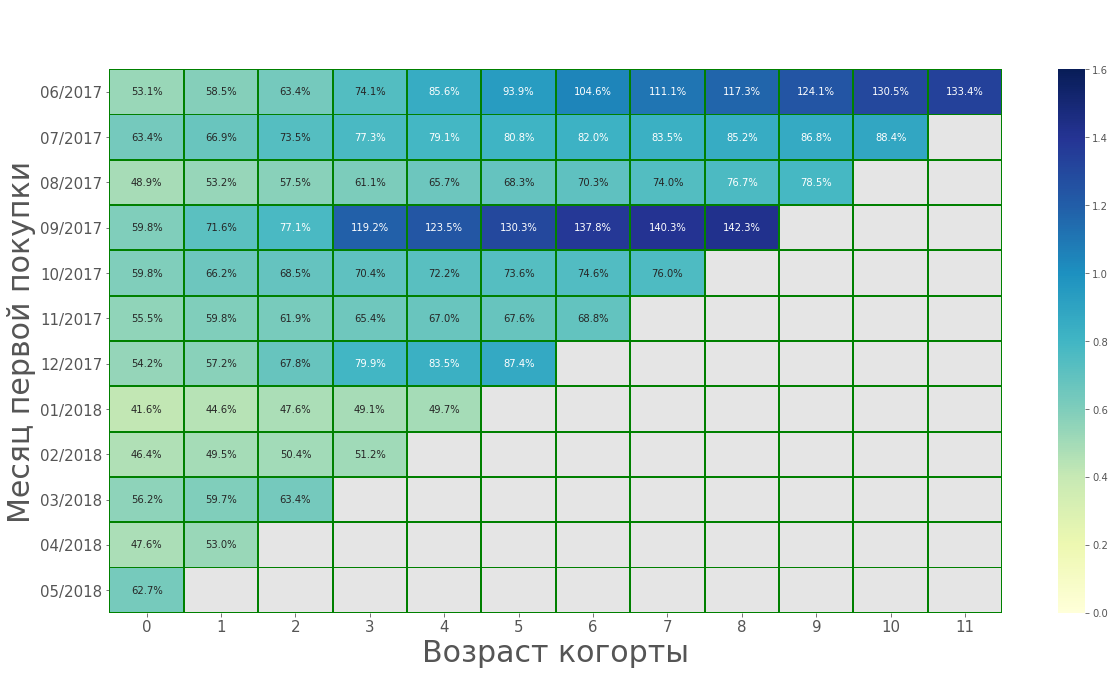

In [42]:
#ROMI по всем каналам
monthly_costs = df_costs.groupby('month_of_commercial').sum()
monthly_costs
report_new = pd.merge(report, monthly_costs, left_on = 'first_order_month', 
                      right_on = 'month_of_commercial')
report_new['cac'] = report_new['cost_for_marketing_source'] / report_new['n_buyers']
report_new['romi'] = report_new['ltv'] / report_new['cac']
output_mark = report_new.pivot_table(index='first_order_month', columns='age', 
                                     values='romi', aggfunc='mean')
print('Средний LTV за 6 месяцев после первой покупки:', m6_cum_ltv)
output_mark = output_mark.cumsum(axis=1)
output_mark.index = output_mark.index.strftime("%m/%Y")
plt.figure(figsize=(20, 10))
sns.heatmap(output_mark, fmt='.1%', annot=True, linewidths=1, 
            linecolor='green', cmap="YlGnBu", vmin=0, vmax=1.6)
plt.ylabel('Меcяц первой покупки', fontsize=30)
plt.xlabel('Возраст когорты', fontsize=30)
plt.title('ROMI по всем источникам' + '\n', fontsize=30)
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

In [43]:
print('Средний ROMI по всем когортам', output_mark.dropna().mean().mean().round(2))
average_romi_after_six_months = output_mark.iloc[0:7, 0:6].mean().mean().round(2)
print('Средний ROMI на шестой месяц жизни когорты составляет', average_romi_after_six_months)

Средний ROMI по всем когортам 0.96
Средний ROMI на шестой месяц жизни когорты составляет 0.72


Здесь необходимо сделать небольшую оговорку. Глядя на данные, можно понять, что на распределение нашего реального роми сильно повлияли необычные значения метрики, которые продемонстрировали 1-я и 4-я когорты. Поэтому важно осозновать, глядя на эти цифры, что реальный ROMI большинства когорт в наших данных будет ниже. 

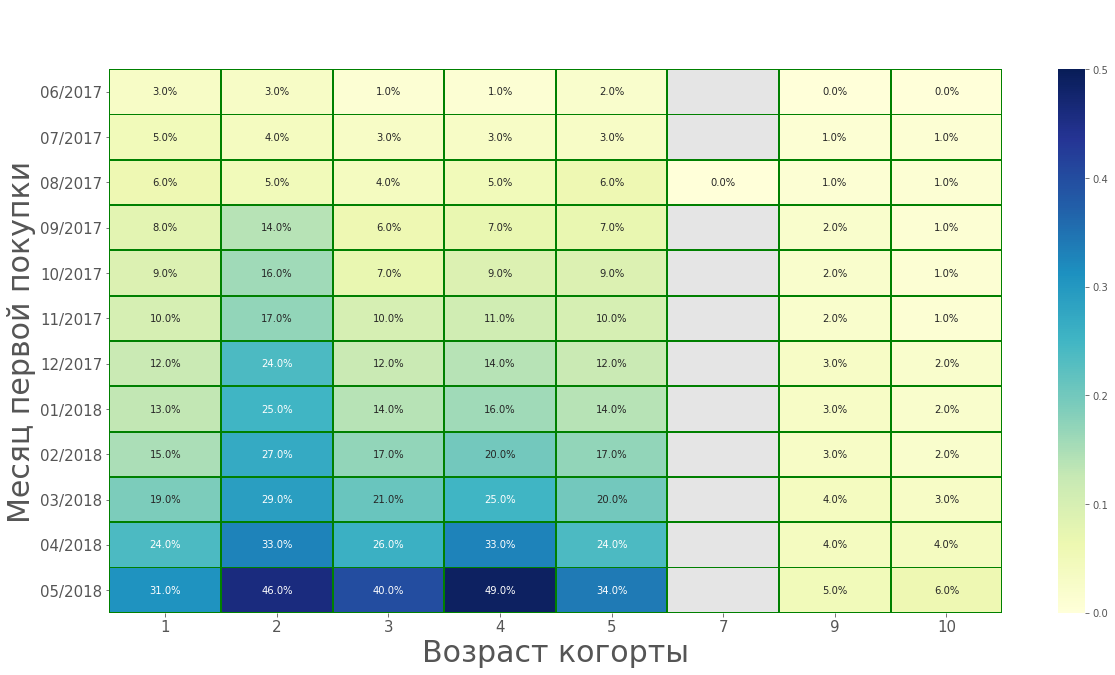

In [44]:
costs_sources = df_costs.groupby('month_of_commercial').sum()
report_source_new = pd.merge(report_source, costs_sources, left_on='first_order_month',
                             right_on='month_of_commercial')
report_source_new['cac'] = report_source_new['cost_for_marketing_source'] / report_source_new['n_buyers']
report_source_new['romi'] = report_source_new['ltv'] / report_source_new['cac']
output_source = report_source_new.pivot_table(index='first_order_month', 
                                              columns='commercial_source_id', values='romi', aggfunc='mean')
output_source = output_source.cumsum(axis = 0).round(2)
output_source.fillna('')
#print(output_source)
output_source.index = output_source.index.strftime("%m/%Y")
plt.figure(figsize=(20, 10))
sns.heatmap(output_source, fmt='.1%', annot=True, linewidths=1, linecolor='green', cmap="YlGnBu", vmin=0, vmax=0.5)
plt.ylabel('Меcяц первой покупки', fontsize=30)
plt.xlabel('Возраст когорты', fontsize=30)
plt.title('ROMI по всем маркетинговым источникам' + '\n', fontsize=30)
plt.yticks(rotation=0, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

## Выводы 
- у нас большая проблема с окупаемостью когорт - окупились только две, первая и четвертая. 
- у нас плохо окупается маркетинг, самый перспективный канал - 4. Даже он окупился лишь на 49 %. 
- надо или менять саму рекламу, или искать новые маркетинговые каналы. 

# Итоговые выводы

*Мы проанализировали посещения, продажи и затраты Яндекс Афиши. У продукта есть сезонность. Люди значительно увеличивают покупки в ноябре и декабре и значительно их снижают в январе. В результате анализа выяснилось, что продукт убыточный. Несмотря на то, что у нашего продукта в целом довольно высокий retention rate (4.6%), наш продукт, если делать выводы по имеющимся данным, пока не может принести нам прибыль.*

Тем не менее из исследования понятно, что у нас есть несколько точек потенциального роста.

- Во-первых, это разработка удобного мобильного приложения(или улучшение текущего). На данный момент мобильной версией Я.Афиши пользуется лишь 1/4 от всех пользователей. Учитывая, что делать покупки с развитием технологий как apple pay стало гораздо проще, то можно предположить, что и продажи Я.Афиши пойдут вверх, если привлекать больше пользователей заходить на сайт с мобильного устройста.

- Во-вторых, мы много денег тратим на неочевидный маркетинговый канал под номером 3. Его ROMI составляет лишь 40 %, что катастрофически мало. Но и в целом, если говорить про маркетинг, то ROMI нигде не превышает 50 %. Это свидетельствует или о плохо составленной рекламе, или об охвате данными каналами не того пользователя, чью проблему должен решить наш продукт.

- На данный момент самым перспективным каналом выглядит 4, но и у него окупаемость лишь 49%.  